# Libraries

In [2]:
import pandas as pd
import numpy as np
import datetime
import random
from pandas_profiling import ProfileReport
import cufflinks as cf
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.impute import SimpleImputer
from category_encoders.woe import WOEEncoder
from scipy.stats import ks_2samp
import plotly.express as px
from sklearn.preprocessing import StandardScaler,MinMaxScaler,KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import json
import seaborn as sns
import os
import pickle
import functools
cf.go_offline()
pd.set_option('max_columns',500)

# Functions

In [3]:
def get_use_model(aux_):
    aux_['Total']=aux_[0]+aux_[1]
    aux_['%Dist']=aux_['Total']/aux_['Total'].sum()
    aux_['TNE']=aux_[0]/aux_['Total']
    aux_['TE']=aux_[1]/aux_['Total']
    aux_['Acum NE']=aux_[0].cumsum()/aux_[0].sum()
    aux_['Acum E']=aux_[1].cumsum()/aux_[1].sum()
    aux_['Dif']=abs(aux_['Acum NE']-aux_['Acum E'])
    aux_['Lift']=aux_['TE']/aux_['TE'].sum()
    aux_['WoE']=np.log(aux_['TNE']/aux_['TE'])
    aux_['IV']=(aux_['TNE']-aux_['TE'])*aux_['WoE']
    print('IV: '+str(round(aux_['IV'].sum(),2)))
    return aux_

def get_graphs(aux_):
    x=[str(y) for y in aux_['p']]
    data = [
        go.Pie(labels=x,
                   values=list(aux_['%Dist']),
                  name='%Dist'
                  ),
           ]
    layout = go.Layout( title = '%Dist')
    fig = go.Figure(data=data, layout=layout)
    display(iplot(fig))
    data = [
        go.Bar(x=x,
                   y=list(aux_['%Dist']),
                  name='%Dist'
                  ),
           ]
    layout = go.Layout(barmode='stack', title = '%Dist')
    fig = go.Figure(data=data, layout=layout)
    display(iplot(fig))
    data = [
        go.Bar(x=x,
                   y=list(aux_['TNE']),
                  name='TNE'
                  ),

           go.Bar(x=x,
                   y=list(aux_['TE']),
                 name='TE'
                 )
           ]
    layout = go.Layout(barmode='stack', title = 'TE/TNE')
    fig = go.Figure(data=data, layout=layout)
    display(iplot(fig))
    
    print('KS: '+str(max(aux_['Dif'])))
    data = [
        go.Scatter(x=['']+x,
                   y=[0]+list(aux_['Acum NE']),
                  name='Acum NE',line_shape='spline'
                  ),

           go.Scatter(x=['']+x,
                   y=[0]+list(aux_['Acum E']),
                 name='Acum E',line_shape='spline'
                 )
           ]
    layout = go.Layout( title = 'KS')
    fig = go.Figure(data=data, layout=layout)
    display(iplot(fig))
    
    data = [
        go.Scatter(x=['']+x,
                   y=[0]+list(aux_['Lift']),
                  name='Lift',
                   line_shape='spline'
                  ),

           ]
    layout = go.Layout( title = 'Lift',)
    fig = go.Figure(data=data, layout=layout)
    display(iplot(fig))
    
def normalize(df,feat,threshold=0.05):
    # A function that normalize a dataframe column given a theshold of missings percentage and return dataframe transdormed and transform dictionary
    dc_norm={}
    for f in feat:
        aux = df[f].value_counts(True).to_frame()
        aux['ok'] = (aux[f]>=threshold).astype(int)
        biggest = list(aux.index)[0]
        if len(aux.loc[aux.ok==0])>0:
            aux = aux.loc[aux.ok==0]
            aux['map'] = np.where(aux[f].sum()>=threshold,'OTHER',biggest)
            aux.drop([f,'ok'],axis=1,inplace=True)
            df[f].replace(aux.to_dict()['map'],inplace=True)
            dc_norm[f]=aux.to_dict()['map']
    return df.copy(),dc_norm

# Read data

In [4]:
data_path='../data'
frec=500
data_path=f'../data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/records{frec}'
df_origen = pd.read_csv(os.path.join(data_path,'df_all_lx_to_model_hvr_post_eda.csv'))
df=df1=df_origen.copy()
df_origen

/media/dbh/Seagate Expansion Drive/dbh/Maestría tecnología avanzada/envs/cardiovascular_patterns/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning:

Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.



ecg_id  patient_id   age  sex  height  weight       recording_date  \
0           1     15709.0  56.0    1     NaN    63.0  1984-11-09 09:17:34   
1           2     13243.0  19.0    0     NaN    70.0  1984-11-14 12:55:37   
2           3     20372.0  37.0    1     NaN    69.0  1984-11-15 12:49:10   
3           4     17014.0  24.0    0     NaN    82.0  1984-11-15 13:44:57   
4           5     17448.0  19.0    1     NaN    70.0  1984-11-17 10:43:15   
...       ...         ...   ...  ...     ...     ...                  ...   
21832   21833     17180.0  67.0    1     NaN     NaN  2001-05-31 09:14:35   
21833   21834     20703.0  93.0    0     NaN     NaN  2001-06-05 11:33:39   
21834   21835     19311.0  59.0    1     NaN     NaN  2001-06-08 10:30:27   
21835   21836      8873.0  64.0    1     NaN     NaN  2001-06-09 18:21:49   
21836   21837     11744.0  68.0    0     NaN     NaN  2001-06-11 16:43:01   

      heart_axis infarction_stadium1 infarction_stadium2  validated_by  \
0            NaN                 NaN                 NaN           NaN   
1            NaN                 NaN                 NaN           NaN   
2            NaN                 NaN                 NaN           NaN   
3            NaN                 NaN                 NaN           NaN   
4            NaN                 NaN                 NaN           NaN   
...          ...                 ...                 ...           ...   
21832        LAD                 NaN                 NaN           1.0   
21833        MID      Stadium II-III                 NaN           1.0   
21834        MID                 NaN                 NaN           1.0   
21835        LAD                 NaN                 NaN           1.0   
21836        MID                 NaN                 NaN           1.0   

       second_opinion  initial_autogenerated_report  validated_by_human  \
0               False                         False                True   
1               False                         False                True   
2               False                         False                True   
3               False                         False                True   
4               False                         False                True   
...               ...                           ...                 ...   
21832           False                          True                True   
21833           False                          True                True   
21834            True                          True                True   
21835           False                          True                True   
21836           False                          True                True   

       baseline_drift static_noise burst_noise electrodes_problems  \
0                 NaN    , I-V1,           NaN                 NaN   
1                 NaN          NaN         NaN                 NaN   
2                 NaN          NaN         NaN                 NaN   
3        , II,III,AVF          NaN         NaN                 NaN   
4       , III,AVR,AVF          NaN         NaN                 NaN   
...               ...          ...         ...                 ...   
21832             NaN   , alles,           NaN                 NaN   
21833             NaN          NaN         NaN                 NaN   
21834             NaN   , I-AVR,           NaN                 NaN   
21835             NaN          NaN         NaN                 NaN   
21836             NaN   , I-AVL,           NaN                 NaN   

      extra_beats pacemaker                filename_lr  \
0             NaN       NaN  records100/00000/00001_lr   
1             NaN       NaN  records100/00000/00002_lr   
2             NaN       NaN  records100/00000/00003_lr   
3             NaN       NaN  records100/00000/00004_lr   
4             NaN       NaN  records100/00000/00005_lr   
...           ...       ...                        ...   
21832         1ES       NaN  records100/21000

# Train test split

In [5]:
target=tgt='NOT_NORM'

In [6]:
df_origen.shape

(21837, 506)

In [7]:
random_state=int(np.random.uniform(0,1000))
print(random_state)
df_origen_train,Xval,y_train,yval = train_test_split(df_origen,df_origen[tgt],train_size=0.9,random_state=random_state)
df_origen_train.reset_index(inplace=True,drop=True)
Xval.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
yval.reset_index(inplace=True,drop=True)
Xt,Xv,yt,yv = train_test_split(df_origen_train,y_train,train_size=0.8,random_state=random_state)
Xt.reset_index(inplace=True,drop=True)
Xv.reset_index(inplace=True,drop=True)
yt.reset_index(inplace=True,drop=True)
yv.reset_index(inplace=True,drop=True)

578


In [8]:
Xt.shape

(15722, 506)

18

# Pre-cleaning

## Feature selection

In [9]:
dc_feat={
 'dates': ['recording_date'],
 'lists':[],
         'texts': [],
  'ids': ['ecg_id', 'patient_id', 'filename_lr', 'filename_hr',
       'file_name'],
'target':'NOT_NORM',
    #Estas se identifican automaticamente
'continuous': [],
 'discretes': [],
}


In [10]:
dc_feat['continuous']=list(map(lambda x: x[0],filter(lambda x: x[1]==int,zip(df.dtypes.index,df.dtypes))))+list(map(lambda x: x[0],filter(lambda x: x[1]==float,zip(df.dtypes.index,df.dtypes))))
dc_feat['continuous']=list((set(dc_feat['continuous'])-functools.reduce(lambda x,y: set(x).union(set(y)) , [dc_feat[x] for x in dc_feat if x!= 'continuous']))-set([dc_feat['target']]))
dc_feat['discretes']=list(set(map(lambda x: x[0],filter(lambda x: str(x[1])=="object",zip(df.dtypes.index,df.dtypes))))-(functools.reduce(lambda x,y: set(x).union(set(y)) , dc_feat.values())))
dc_feat
                           

{'dates': ['recording_date'],
 'lists': [],
 'texts': [],
 'ids': ['ecg_id', 'patient_id', 'filename_lr', 'filename_hr', 'file_name'],
 'target': 'NOT_NORM',
 'continuous': ['V6_tP_tR',
  'III_tR_tS',
  'II_tP_tQ',
  'V1_tP_tS',
  'V2_tR_std',
  'V3_tT',
  'AVF_tQ_tS',
  'I_yR',
  'AVL_tS',
  'V2_yR_yT',
  'I_tP_tR',
  'V5_tT',
  'AVL_yP_yS',
  'V6_yP_yQ',
  'V2_yT',
  'V4_tQ_std',
  'V6_yP_yS',
  'I_tR_tT',
  'V1_tQ',
  'AVR_tR_tS',
  'AVF_yP_std',
  'AVF_tQ_std',
  'AVR_tR_tT',
  'V5_yR',
  'II_tQ_std',
  'V2_tQ_tR',
  'V1_tT_std',
  'II_tP',
  'V4_tP_std',
  'V2_yS',
  'V2_yQ_yR',
  'AVL_tR_tT',
  'V1_tP_tR',
  'V5_tS_std',
  'V3_yP_yS',
  'V3_yQ',
  'V1_tR_std',
  'III_yT',
  'V5_tP_tQ',
  'V6_yP_std',
  'V5_yP_yS',
  'I_yQ_yR',
  'AVR_yQ_yS',
  'V3_tR_tT',
  'II_yP_yS',
  'I_yP_yQ',
  'AVL_yQ_std',
  'V3_tQ',
  'I_yS',
  'AVR_yQ_std',
  'AVL_tP_tR',
  'AVL_yQ',
  'II_yQ_yS',
  'V2_yQ_yT',
  'AVF_yR_yS',
  'AVF_yR_std',
  'V6_tS',
  'AVR_tQ_tR',
  'V1_yS_yT',
  'II_yR_yS',
  'V4_yT

In [11]:
dc_feat['continuous']=['V5_yP_yT',
 'V1_yP_yQ',
 'II_yP_yT',
 'III_yP_yS',
 'I_yQ_yT',
 'II_yP_yS',
 'II_yQ_yR',
 'I_tP_tS',
 'AVL_tQ_tS',
 'V5_yR_yS',
 'V2_yP_yR',
 'V1_tQ_tS',
 'II_tQ_tR',
 'V4_yR_yT',
 'III_yP_yQ',
 'V2_tR_tT',
 'AVR_yR_yT',
 'V3_tP_tQ',
 'V5_yP_yQ',
 'II_tS_tT',
 'II_tP_tQ',
 'V2_tR_tS',
 'V3_yP_yT',
 'I_tS_tT',
 'sex_']

In [12]:
{x:len(dc_feat[x]) for x in dc_feat.keys()}

{'dates': 1,
 'lists': 0,
 'texts': 0,
 'ids': 5,
 'target': 8,
 'continuous': 25,
 'discretes': 10}

## Discretize continuous features

In [13]:
from sklearn import tree
dc_disc={}
disc_meth='tree'
max_depth_disc=5
include_inf=True
# ls_to_bin=['II_yP_yR']
ls_to_bin=dc_feat['continuous'][:-1]
for col in ls_to_bin:
    if disc_meth=='equi':
        didc_discsc_meth[col]=[float(str(x).split(',')[0]).replace('(','') for x in pd.cut(Xt[col],4).unique()]
    if disc_meth=='quantile':
        dc_disc[col]=[float(str(x).split(',')[0]).replace('(','') for x in pd.qcut(Xt[col],q=[0,.25,.5,.75,1]).unique()]
    if disc_meth=='tree':
        clf=tree.DecisionTreeClassifier(max_depth=max_depth_disc)
        if Xt[col].isnull().sum()>0:
            aux_col=Xt[col].fillna(Xt[col].median()).to_frame()
        clf=clf.fit(aux_col,yt)
        aux=pd.DataFrame(zip(aux_col[col],yt),columns=[col,dc_feat['target']])
        aux[f'{col}_tree']=clf.predict_proba(aux_col)[:,1]
        aux_=aux.groupby([f'{col}_tree']).agg({col:[min,max]})
        aux_.columns=['_'.join(x) for x in aux_.columns]
        aux_.sort_values([f'{col}_tree'],inplace=True)
        dc_disc[col]=list(aux_[f'{col}_min'].values)
    if include_inf:
        dc_disc[col]=[-np.inf]+dc_disc[col]+[np.inf]
    dc_disc[col]=sorted(dc_disc[col])
    Xt[f'bin_{col}']=pd.cut(x=Xt[col],bins=dc_disc[col]).astype(str)
    Xv[f'bin_{col}']=pd.cut(x=Xv[col],bins=dc_disc[col]).astype(str)
    Xval[f'bin_{col}']=pd.cut(x=Xval[col],bins=dc_disc[col]).astype(str)
    df[f'bin_{col}']=pd.cut(x=df[col],bins=dc_disc[col]).astype(str)
dc_feat['discretes']=[f'bin_{col}' for col in ls_to_bin]
pickle.dump(dc_disc, open('../transforms/dc_disc.pkl', 'wb'))

## get original shape

In [14]:
original_shape=Xt.shape
print(original_shape)

(15722, 530)


# Exploratory Data Analysis 

## 1-d

### Histograms

In [15]:
for col in random.sample(dc_feat['continuous'],min(10,len(dc_feat['continuous']))):
    display(Xt.sample(frac=.1)[col].iplot(kind='hist',color='blue',bins=10,title=col))

None

None

None

None

None

None

None

None

None

None

### Pies

In [16]:
for col in random.sample(dc_feat['discretes'],min(10,len(dc_feat['discretes']))):
    Xt.sample(frac=.1).iplot(kind='pie',title=col, labels=col,values=dc_feat['ids'][0])

In [17]:
df['diagnostic_class'].nunique()

153

## 2-d

In [18]:
Xt[dc_feat['continuous']].corr()

V5_yP_yT  V1_yP_yQ  II_yP_yT  III_yP_yS   I_yQ_yT  II_yP_yS  \
V5_yP_yT   1.000000  0.092267  0.565293   0.126648  0.355039  0.056779   
V1_yP_yQ   0.092267  1.000000  0.035564   0.130997  0.018759  0.190616   
II_yP_yT   0.565293  0.035564  1.000000   0.025733  0.439434  0.035275   
III_yP_yS  0.126648  0.130997  0.025733   1.000000 -0.071791  0.668747   
I_yQ_yT    0.355039  0.018759  0.439434  -0.071791  1.000000 -0.029152   
II_yP_yS   0.056779  0.190616  0.035275   0.668747 -0.029152  1.000000   
II_yQ_yR   0.260283  0.002797  0.312585   0.201531  0.246569  0.049847   
I_tP_tS   -0.086042  0.077404 -0.069305  -0.025136 -0.027810  0.015750   
AVL_tQ_tS -0.038887  0.024537 -0.027734  -0.158891 -0.000481 -0.097805   
V5_yR_yS  -0.235713  0.068692 -0.067355   0.037143 -0.096459  0.149129   
V2_yP_yR   0.123696  0.124641  0.122116   0.025978  0.195697 -0.008248   
V1_tQ_tS  -0.030372 -0.123173 -0.041335  -0.032534 -0.029822 -0.037560   
II_tQ_tR   0.009244  0.022799 -0.024849  -0.018392  0.011028 -0.017307   
V4_yR_yT   0.016355 -0.078226  0.035973  -0.146271 -0.064507 -0.076371   
III_yP_yQ  0.074492  0.125172  0.050708  -0.061169 -0.045261  0.038409   
V2_tR_tT  -0.086323 -0.034206 -0.038017  -0.040620 -0.044966 -0.036717   
AVR_yR_yT -0.188582  0.013719 -0.231688   0.038373 -0.232346  0.314786   
V3_tP_tQ   0.037462  0.092142  0.002135   0.049020  0.052382  0.041926   
V5_yP_yQ  -0.042505  0.096572 -0.132907   0.103464 -0.247941  0.200978   
II_tS_tT  -0.075418 -0.034367 -0.090661  -0.083982 -0.044830 -0.121388   
II_tP_tQ   0.003377  0.049411 -0.057706   0.052112 -0.003429  0.040586   
V2_tR_tS  -0.019211 -0.104879  0.002491  -0.085070 -0.019717 -0.076124   
V3_yP_yT   0.495458  0.017223  0.333976  -0.012222  0.182159 -0.020677   
I_tS_tT   -0.022568 -0.013488 -0.029212   0.000394 -0.025003  0.022110   
sex_      -0.060586  0.044221 -0.007311  -0.022727 -0.005108 -0.014600   

           II_yQ_yR   I_tP_tS  AVL_tQ_tS  V5_yR_yS  V2_yP_yR  V1_tQ_tS  \
V5_yP_yT   0.260283 -0.086042  -0.038887 -0.235713  0.123696 -0.030372   
V1_yP_yQ   0.002797  0.077404   0.024537  0.068692  0.124641 -0.123173   
II_yP_yT   0.312585 -0.069305  -0.027734 -0.067355  0.122116 -0.041335   
III_yP_yS  0.201531 -0.025136  -0.158891  0.037143  0.025978 -0.032534   
I_yQ_yT    0.246569 -0.027810  -0.000481 -0.096459  0.195697 -0.029822   
II_yP_yS   0.049847  0.015750  -0.097805  0.149129 -0.008248 -0.037560   
II_yQ_yR   1.000000 -0.066960  -0.055319 -0.354622  0.251939 -0.039905   
I_tP_tS   -0.066960  1.000000   0.266742  0.031791 -0.017401  0.054629   
AVL_tQ_tS -0.055319  0.266742   1.000000  0.014591 -0.010249  0.008338   
V5_yR_yS  -0.354622  0.031791   0.014591  1.000000 -0.179088 -0.004136   
V2_yP_yR   0.251939 -0.017401  -0.010249 -0.179088  1.000000 -0.006628   
V1_tQ_tS  -0.039905  0.054629   0.008338 -0.004136 -0.006628  1.000000   
II_tQ_tR  -0.054464  0.136187   0.009500  0.017787 -0.001094  0.028034   
V4_yR_yT  -0.390074 -0.007595   0.003542  0.526703 -0.411505  0.017976   
III_yP_yQ -0.038265  0.068414   0.137541  0.031627 -0.085732 -0.019840   
V2_tR_tT  -0.063468 -0.021590  -0.005008  0.050849 -0.032508  0.008014   
AVR_yR_yT -0.071645  0.011033  -0.014619  0.127022 -0.161118 -0.011796   
V3_tP_tQ   0.029973  0.071280   0.010702 -0.004843  0.062672  0.020751   
V5_yP_yQ  -0.420942  0.073499  -0.003745  0.265120 -0.166746  0.025419   
II_tS_tT  -0.014821 -0.014976   0.042686 -0.023026 -0.004802  0.000535   
II_tP_tQ  -0.008941  0.154355   0.005702  0.004267  0.014467  0.049602   
V2_tR_tS  -0.052903 -0.011937   0.007864  0.032067 -0.114787  0.047110   
V3_yP_yT   0.172847 -0.010237  -0.016044 -0.201730  0.035550  0.037332   
I_tS_tT   -0.032168 -0.112870  -0.032846  0.007171 -0.037461 -0.011196   
sex_       0.070655 -0.020021  -0.000462  0.174191 -0.094430 -0.051399   

           II_tQ_tR  V4_yR_yT  III_yP_yQ  V2_tR_tT  AVR_yR_yT  V3_tP_tQ  \
V5_yP_yT   0.009244  0.016355   0.074492 -0.086323  -0.188582  0.037462   
V1_yP_yQ   

In [19]:
# pickle.dump(dc_feat, open('../transforms/dc_feat_before_kbinsdiscretizer.pkl', 'wb'))
# est = KBinsDiscretizer(encode='onehot-dense',strategy='quantile')
# aux=est.fit_transform(Xt[dc_feat['continuous']])
# pd.DataFrame(aux,columns=dc_feat['continuous'])

## Normalize

In [20]:
# for v in dc_feat['discretes']:
#     Xt[v] = Xt[v].fillna('MISSING').astype(str)
#     Xv[v] = Xv[v].fillna('MISSING').astype(str)
#     Xval[v] = Xval[v].fillna('MISSING').astype(str)
    
# Xt,dc_norm=normalize(Xt,dc_feat['discretes'],threshold=0.05)

# # for col in dc_transforms.keys():
# #     Xv[col]=Xv[col].map(dc_transforms[col])
# for col in dc_norm.keys():
#     Xv[col]=Xv[col].map(lambda x: x if x not in dc_norm[col].keys() else dc_norm[col][x])
#     Xval[col]=Xval[col].map(lambda x: x if x not in dc_norm[col].keys() else dc_norm[col][x])
    
# for col in random.sample(dc_feat['discretes'],min(10,len(dc_feat['discretes']))):
#     Xt.sample(frac=.1).iplot(kind='pie',title=col, labels=col,values=dc_feat['ids'][0])
# dc_norm

## WOE transformation (discrete variables)

In [21]:
pickle.dump(dc_feat, open('../transforms/dc_feat_before_woe.pkl', 'wb'))
WOE_encoder = WOEEncoder()
Xt_woe = WOE_encoder.fit_transform(Xt[dc_feat['discretes']], Xt[tgt])
Xt_woe.rename(columns={x:x+'_woe' for x in Xt_woe.columns},inplace=True)
Xt=Xt.merge(Xt_woe, right_index=True, left_index=True)
#test
Xv_woe = WOE_encoder.transform(Xv[dc_feat['discretes']])
Xv_woe.rename(columns={x:x+'_woe' for x in Xv_woe.columns},inplace=True)
Xv=Xv.merge(Xv_woe, right_index=True, left_index=True)
#validate
Xval_woe = WOE_encoder.transform(Xval[dc_feat['discretes']])
Xval_woe.rename(columns={x:x+'_woe' for x in Xval_woe.columns},inplace=True)
Xval=Xval.merge(Xval_woe, right_index=True, left_index=True)

Xt

ecg_id  patient_id   age  sex  height  weight       recording_date  \
0        5513     18003.0  54.0    0     NaN     NaN  1990-12-12 12:39:50   
1       19143     19746.0  58.0    0     NaN     NaN  1998-01-25 09:31:53   
2       10684      1912.0  80.0    1   165.0    60.0  1993-07-28 09:35:20   
3       14766     19348.0  71.0    1     NaN     NaN  1995-08-15 08:14:05   
4        2364     10096.0  18.0    1     NaN    57.0  1988-11-28 14:43:43   
...       ...         ...   ...  ...     ...     ...                  ...   
15717   13907     12364.0  49.0    1     NaN     NaN  1995-03-23 11:42:16   
15718   21774      9993.0  74.0    0     NaN     NaN  2001-01-28 07:58:54   
15719   16911     12833.0  25.0    1     NaN     NaN  1996-09-24 10:36:03   
15720   13620     19407.0  72.0    0     NaN     NaN  1995-01-17 13:46:03   
15721   18901     19579.0  48.0    0     NaN     NaN  1997-11-26 08:50:09   

      heart_axis infarction_stadium1 infarction_stadium2  validated_by  \
0            LAD             unknown                 NaN           NaN   
1            LAD             unknown                 NaN           NaN   
2            NaN                 NaN                 NaN           0.0   
3            LAD             unknown                 NaN           NaN   
4            NaN                 NaN                 NaN           NaN   
...          ...                 ...                 ...           ...   
15717        MID                 NaN                 NaN           1.0   
15718        MID                 NaN                 NaN           NaN   
15719        MID                 NaN                 NaN           NaN   
15720       ALAD                 NaN                 NaN           NaN   
15721        MID             unknown                 NaN           NaN   

       second_opinion  initial_autogenerated_report  validated_by_human  \
0               False                          True               False   
1               False                          True               False   
2               False                         False                True   
3               False                          True               False   
4               False                         False                True   
...               ...                           ...                 ...   
15717           False                         False                True   
15718           False                          True               False   
15719           False                          True               False   
15720           False                          True               False   
15721           False                          True               False   

      baseline_drift static_noise burst_noise electrodes_problems  \
0                NaN          NaN         NaN                 NaN   
1                NaN   , I-AVR,           NaN                 NaN   
2                NaN          NaN         NaN                 NaN   
3                NaN          NaN         NaN                 NaN   
4                NaN          NaN         NaN                 NaN   
...              ...          ...         ...                 ...   
15717            NaN          NaN         NaN                 NaN   
15718            NaN          NaN         NaN                 NaN   
15719            NaN          NaN         NaN                 NaN   
15720            NaN          NaN         NaN                 NaN   
15721            NaN          NaN         NaN                 NaN   

           extra_beats pacemaker                filename_lr  \
0                  NaN       NaN  records100/05000/05513_lr   
1                  NaN       NaN  records100/19000/19143_lr   
2                  NaN       NaN  records100/10000/10684_lr   
3                  NaN       NaN  records100/14000/14766_lr   
4                  NaN       NaN  records100/02000/02364_lr   
...                ...       ...                        ...   
15717              NaN

In [22]:
# dc_feat={}
# dc_feat['ids']=['ID']
# dc_feat['target']=tgt
# dc_feat['tgt']=tgt
# dc_feat['continuous']=[z[0] for z in zip(Xt.dtypes.index,Xt.dtypes.values) if ((z[1]==int or z[1]==float)and not(z[0] in dc_feat['ids'] or z[0] in dc_feat['tgt']) )] 
# dc_feat['dates']=list(Xt.select_dtypes(include=[np.datetime64]).columns)
# dc_feat['discretes']=[z[0] for z in zip(Xt.dtypes.index,Xt.dtypes.values) if (z[1]==type(str)) and not(z[0] in dc_feat['ids']  or z[0] in dc_feat['tgt'])]
# dc_feat['texts']=[]


# dc_feat

In [23]:
dc_woe={}
for x,y in zip([x.replace('_woe','') for x in Xt.columns if 'woe' in x],[x for x in Xt.columns if 'woe' in x]):
    dc_woe.update({x:dict(zip(Xt[x].value_counts().keys(),Xt[y].value_counts().keys()))})
dc_woe

{'bin_V5_yP_yT': {'(0.2708, 0.82667]': -1.0665871426399196,
  '(0.16064, 0.21917]': -0.572000785716199,
  '(-0.27587, -0.0278]': 3.936529621577345,
  '(0.21917, 0.2708]': -0.8670880277307038,
  'nan': 0.2974823686313235,
  '(0.12078, 0.15543]': -0.3183229209674804,
  '(-0.0018889, 0.0332]': 2.0219653433830813,
  '(0.094, 0.12078]': 0.017590031522822878,
  '(0.0709, 0.094]': 0.46151670817881735,
  '(0.040875, 0.059176]': 0.983813132145187,
  '(-0.027786, -0.0035]': 2.995863083705045,
  '(0.059786, 0.0709]': 0.6816668297833217,
  '(0.035111, 0.040875]': 1.8384102950140022,
  '(0.82667, inf]': 0.7507100397968749,
  '(-1.7745, -0.27587]': 2.4850374599390546,
  '(0.1584, 0.16064]': -0.9604957355431525,
  '(0.15543, 0.15736]': -1.114045995058167,
  '(0.0332, 0.035111]': 0.7622708621979511,
  '(-0.0035, -0.0018889]': 1.355334584200914,
  '(0.15736, 0.1584]': 0.1600954598437325,
  '(0.059182, 0.059786]': 2.1485652233178416,
  '(0.059176, 0.059182]': 0.0},
 'bin_V1_yP_yQ': {'(-0.07891, -0.0261]

In [24]:
dc_feat['continuous']=dc_feat['continuous']+[x for x in Xt.columns if x.endswith('_woe')]

## Varclus

In [25]:
from varclushi import VarClusHi

In [26]:
im = SimpleImputer(strategy='median')
vc = VarClusHi(pd.DataFrame(im.fit_transform(Xt[dc_feat['continuous']]),columns=dc_feat['continuous']),maxeigval2=1)

vc.varclus()
aux = vc.rsquare
aux.sort_values(['Cluster','RS_Ratio'],inplace=True)
aux.reset_index(drop=True,inplace=True)
aux['k'] = aux.groupby('Cluster').cumcount()+1
aux

Cluster           Variable    RS_Own     RS_NC  RS_Ratio  k
0        0          III_yP_yS  0.840080  0.133879  0.184639  1
1        0  bin_III_yP_yS_woe  0.819757  0.132041  0.207663  2
2        0   bin_II_yP_yS_woe  0.709680  0.065356  0.310621  3
3        0           II_yP_yS  0.700814  0.053553  0.316114  4
4        0   bin_II_yQ_yR_woe  0.281862  0.156543  0.851422  5
5        0  bin_AVL_tQ_tS_woe  0.390680  0.297544  0.867413  6
6        0          AVL_tQ_tS  0.033143  0.022803  0.989419  7
7        1           V5_yP_yT  0.646106  0.143670  0.413269  1
8        1   bin_V5_yP_yT_woe  0.654129  0.181672  0.422656  2
9        1   bin_II_yP_yT_woe  0.585081  0.108131  0.465224  3
10       1           II_yP_yT  0.537123  0.058855  0.491823  4
11       1            I_yQ_yT  0.336389  0.064227  0.709158  5
12       1    bin_I_yQ_yT_woe  0.425327  0.235327  0.751528  6
13       1          AVR_yR_yT  0.138238  0.125303  0.985212  7
14       2    bin_I_tP_tS_woe  0.634511  0.125715  0.418043  1
15       2    bin_I_tS_tT_woe  0.611087  0.110372  0.437163  2
16       2  bin_AVR_yR_yT_woe  0.516281  0.098496  0.536569  3
17       3          III_yP_yQ  0.955159  0.031305  0.046290  1
18       3  bin_III_yP_yQ_woe  0.952705  0.029229  0.048719  2
19       3            I_tP_tS  0.015212  0.018938  1.003798  3
20       4   bin_V1_yP_yQ_woe  0.838951  0.109278  0.180808  1
21       4           V1_yP_yQ  0.828705  0.073091  0.184802  2
22       4   bin_V1_tQ_tS_woe  0.473028  0.085430  0.576196  3
23       5           II_yQ_yR  0.606616  0.067922  0.422050  1
24       5           V5_yR_yS  0.517764  0.053911  0.509715  2
25       5           V2_yP_yR  0.384796  0.169937  0.741153  3
26       5            I_tS_tT  0.010336  0.008187  0.997834  4
27       6   bin_V3_yP_yT_woe  0.647461  0.135173  0.407641  1
28       6   bin_V2_tR_tT_woe  0.503763  0.056430  0.525914  2
29       6           V3_yP_yT  0.522623  0.151555  0.562650  3
30       6           V2_tR_tT  0.219874  0.043208  0.815356  4
31       7   bin_V5_yP_yQ_woe  0.643618  0.082883  0.388589  1
32       7           V5_yP_yQ  0.629614  0.160198  0.441040  2
33       7   bin_II_tQ_tR_woe  0.273514  0.070537  0.781619  3
34       7               sex_  0.041478  0.031549  0.989747  4
35       8   bin_V2_tR_tS_woe  0.527089  0.106636  0.529360  1
36       8   bin_V2_yP_yR_woe  0.483123  0.093749  0.570347  2
37       8           V2_tR_tS  0.318720  0.021259  0.696078  3
38       8           V4_yR_yT  0.300585  0.333300  1.049069  4
39       9           V3_tP_tQ  0.703796  0.029544  0.305221  1
40       9   bin_V3_tP_tQ_woe  0.703796  0.083754  0.323280  2
41      10           II_tS_tT  0.634871  0.014034  0.370326  1
42      10   bin_II_tS_tT_woe  0.634871  0.133529  0.421397  2
43      11           II_tP_tQ  0.550210  0.014975  0.456628  1
44      11   bin_II_tP_tQ_woe  0.470459  0.047453  0.555921  2
45      11           II_tQ_tR  0.210229  0.014508  0.801398  3
46      12   bin_V5_yR_yS_woe  0.673971  0.061179  0.347275  1
47      12   bin_V4_yR_yT_woe  0.673971  0.155803  0.386200  2
48      13           V1_tQ_tS  1.000000  0.039407  0.000000  1

In [27]:
dc_feat['continuous'] = (aux.loc[aux.k==1])['Variable'].to_list()
# Xt=Xt[dc_feat['continuous']].copy()
# Xv=Xv[dc_feat['continuous']].copy()
dc_feat

{'dates': ['recording_date'],
 'lists': [],
 'texts': [],
 'ids': ['ecg_id', 'patient_id', 'filename_lr', 'filename_hr', 'file_name'],
 'target': 'NOT_NORM',
 'continuous': ['III_yP_yS',
  'V5_yP_yT',
  'bin_I_tP_tS_woe',
  'III_yP_yQ',
  'bin_V1_yP_yQ_woe',
  'II_yQ_yR',
  'bin_V3_yP_yT_woe',
  'bin_V5_yP_yQ_woe',
  'bin_V2_tR_tS_woe',
  'V3_tP_tQ',
  'II_tS_tT',
  'II_tP_tQ',
  'bin_V5_yR_yS_woe',
  'V1_tQ_tS'],
 'discretes': ['bin_V5_yP_yT',
  'bin_V1_yP_yQ',
  'bin_II_yP_yT',
  'bin_III_yP_yS',
  'bin_I_yQ_yT',
  'bin_II_yP_yS',
  'bin_II_yQ_yR',
  'bin_I_tP_tS',
  'bin_AVL_tQ_tS',
  'bin_V5_yR_yS',
  'bin_V2_yP_yR',
  'bin_V1_tQ_tS',
  'bin_II_tQ_tR',
  'bin_V4_yR_yT',
  'bin_III_yP_yQ',
  'bin_V2_tR_tT',
  'bin_AVR_yR_yT',
  'bin_V3_tP_tQ',
  'bin_V5_yP_yQ',
  'bin_II_tS_tT',
  'bin_II_tP_tQ',
  'bin_V2_tR_tS',
  'bin_V3_yP_yT',
  'bin_I_tS_tT']}

In [28]:
len(dc_feat['continuous'])

14

## Save transformations

In [29]:
pickle.dump(dc_feat, open('../transforms/dc_feat.pkl', 'wb'))
# pickle.dump(dc_norm, open('../transforms/dc_norm.pkl', 'wb'))
#pickle.dump(dc_transforms, open('../transforms/dc_transforms.pkl', 'wb'))
pickle.dump(dc_woe, open('../transforms/dc_woe.pkl', 'wb'))
pickle.dump(WOE_encoder, open('../transforms/WOE_encoder.pkl', 'wb'))


## Preprocessing

### Outliers

In [56]:
# Análisis de OL, con respecto a la tgt
# O comparar los resultados con y sin OL

In [57]:
# dc_ol={}
# for v in dc_feat['continuous']:
#     lb,ub = np.percentile(Xt[v].dropna(),0),np.percentile(Xt[v].dropna(),99.99)
#     Xt['ol_%s'%v] = ((Xt[v]<lb)|(Xt[v]>ub)).astype(int)
#     print(v,lb,ub)
#     dc_ol[v]={'lb':lb,'ub':ub}
# ol = [v for v in Xt.columns if v[:2]=='ol']
# Xt['ol_q'] = (Xt[ol].sum(axis=1)>=1).astype(int)
# ol = [v for v in Xt.columns if v[:2]=='ol']
# print(Xt['ol_q'].value_counts(True))
# display(Xt[ol].describe().T.sort_values('mean',ascending=0))
# #Xt.drop(ol,axis=1,inplace=True)
# Xt.reset_index(inplace=True,drop=True)

In [58]:
# Xt['y']=yt

In [59]:
# #These have the same TE
# Xt[Xt['ol_q']==1]['y'].mean()

In [60]:
# Xt.drop(columns=['y'],inplace=True)

In [61]:
# 1-len(Xt[Xt['ol_q']==1])/Xt.shape[0]

In [62]:
# Xt.shape

In [63]:
# len(dc_feat['continuous'])

In [30]:
Xt

ecg_id  patient_id   age  sex  height  weight       recording_date  \
0        5513     18003.0  54.0    0     NaN     NaN  1990-12-12 12:39:50   
1       19143     19746.0  58.0    0     NaN     NaN  1998-01-25 09:31:53   
2       10684      1912.0  80.0    1   165.0    60.0  1993-07-28 09:35:20   
3       14766     19348.0  71.0    1     NaN     NaN  1995-08-15 08:14:05   
4        2364     10096.0  18.0    1     NaN    57.0  1988-11-28 14:43:43   
...       ...         ...   ...  ...     ...     ...                  ...   
15717   13907     12364.0  49.0    1     NaN     NaN  1995-03-23 11:42:16   
15718   21774      9993.0  74.0    0     NaN     NaN  2001-01-28 07:58:54   
15719   16911     12833.0  25.0    1     NaN     NaN  1996-09-24 10:36:03   
15720   13620     19407.0  72.0    0     NaN     NaN  1995-01-17 13:46:03   
15721   18901     19579.0  48.0    0     NaN     NaN  1997-11-26 08:50:09   

      heart_axis infarction_stadium1 infarction_stadium2  validated_by  \
0            LAD             unknown                 NaN           NaN   
1            LAD             unknown                 NaN           NaN   
2            NaN                 NaN                 NaN           0.0   
3            LAD             unknown                 NaN           NaN   
4            NaN                 NaN                 NaN           NaN   
...          ...                 ...                 ...           ...   
15717        MID                 NaN                 NaN           1.0   
15718        MID                 NaN                 NaN           NaN   
15719        MID                 NaN                 NaN           NaN   
15720       ALAD                 NaN                 NaN           NaN   
15721        MID             unknown                 NaN           NaN   

       second_opinion  initial_autogenerated_report  validated_by_human  \
0               False                          True               False   
1               False                          True               False   
2               False                         False                True   
3               False                          True               False   
4               False                         False                True   
...               ...                           ...                 ...   
15717           False                         False                True   
15718           False                          True               False   
15719           False                          True               False   
15720           False                          True               False   
15721           False                          True               False   

      baseline_drift static_noise burst_noise electrodes_problems  \
0                NaN          NaN         NaN                 NaN   
1                NaN   , I-AVR,           NaN                 NaN   
2                NaN          NaN         NaN                 NaN   
3                NaN          NaN         NaN                 NaN   
4                NaN          NaN         NaN                 NaN   
...              ...          ...         ...                 ...   
15717            NaN          NaN         NaN                 NaN   
15718            NaN          NaN         NaN                 NaN   
15719            NaN          NaN         NaN                 NaN   
15720            NaN          NaN         NaN                 NaN   
15721            NaN          NaN         NaN                 NaN   

           extra_beats pacemaker                filename_lr  \
0                  NaN       NaN  records100/05000/05513_lr   
1                  NaN       NaN  records100/19000/19143_lr   
2                  NaN       NaN  records100/10000/10684_lr   
3                  NaN       NaN  records100/14000/14766_lr   
4                  NaN       NaN  records100/02000/02364_lr   
...                ...       ...                        ...   
15717              NaN

In [31]:
# shape_before_outliers=Xt.shape[0]
# for col in dc_feat['continuous']:
#     q_i,q_f=dc_ol[col]['lb'],dc_ol[col]['ub']
#     Xt=Xt[((Xt[col]!=Xt[col])|(q_i<=Xt[col])&(q_f>=Xt[col]))]
#     #print(Xt.shape)
# for col in random.sample(dc_feat['continuous'],min(10,len(dc_feat['continuous']))):
#     display(Xt.sample(frac=.1)[col].iplot(kind='hist',color='blue',bins=10,title=col))
# print(f'Keep: {round(100*Xt.shape[0]/shape_before_outliers,2)}%')

In [32]:
# yt=yt.loc[Xt.index]

## Missings

### Imputer Missings

In [33]:
Xt=Xt[dc_feat['continuous']]
Xv=Xv[dc_feat['continuous']]
Xval=Xval[dc_feat['continuous']]

In [34]:
im = SimpleImputer(strategy='median')
im.fit(Xt)
Xi = pd.DataFrame(im.transform(Xt),columns=dc_feat['continuous'])
l_ks = []
for v in dc_feat['continuous']:
    l_ks.append([v,ks_2samp(Xt[v].dropna(),Xi[v]).statistic])
ks = pd.DataFrame(l_ks,columns=['feat','ks'])
print((ks.ks>=0.15).sum())
if (ks.ks>=0.15).sum()>0:
    print(dc_feat)
    bad_list_=[z[0] for z in zip(ks['feat'],ks['ks']) if z[1]>.15]
    print(f'Not is recomended to imput missing: {bad_list_}')
    for c in dc_feat.keys():
        if c!='target':
            dc_feat[c]=list(set(dc_feat[c])-set(bad_list_))
    Xt=Xt[dc_feat['continuous']].copy()
    Xv=Xv[dc_feat['continuous']].copy()
    Xval=Xval[dc_feat['continuous']].copy()
    im.fit(Xt)
    Xi = pd.DataFrame(im.transform(Xt),columns=dc_feat['continuous'])
    print(f'New features: \n {dc_feat}')
display(ks)

0


feat        ks
0          III_yP_yS  0.001463
1           V5_yP_yT  0.037365
2    bin_I_tP_tS_woe  0.000000
3          III_yP_yQ  0.001463
4   bin_V1_yP_yQ_woe  0.000000
5           II_yQ_yR  0.000986
6   bin_V3_yP_yT_woe  0.000000
7   bin_V5_yP_yQ_woe  0.000000
8   bin_V2_tR_tS_woe  0.000000
9           V3_tP_tQ  0.021499
10          II_tS_tT  0.001113
11          II_tP_tQ  0.000986
12  bin_V5_yR_yS_woe  0.000000
13          V1_tQ_tS  0.001558

In [35]:
Xv = pd.DataFrame(im.transform(Xv),columns=dc_feat['continuous'])

Xt = pd.DataFrame(im.transform(Xt),columns=dc_feat['continuous'])
Xval = pd.DataFrame(im.transform(Xval),columns=dc_feat['continuous'])

In [36]:
Xt.corr()

III_yP_yS  V5_yP_yT  bin_I_tP_tS_woe  III_yP_yQ  \
III_yP_yS          1.000000  0.120643        -0.355910  -0.060819   
V5_yP_yT           0.120643  1.000000        -0.202575   0.070076   
bin_I_tP_tS_woe   -0.355910 -0.202575         1.000000  -0.055705   
III_yP_yQ         -0.060819  0.070076        -0.055705   1.000000   
bin_V1_yP_yQ_woe  -0.167020 -0.125850         0.121186  -0.150160   
II_yQ_yR           0.200626  0.250182        -0.094650  -0.038437   
bin_V3_yP_yT_woe  -0.061826 -0.310064         0.135238  -0.070867   
bin_V5_yP_yQ_woe  -0.115133  0.000757         0.123212  -0.073731   
bin_V2_tR_tS_woe  -0.203172 -0.088050         0.235110  -0.089026   
V3_tP_tQ           0.049479  0.037473        -0.079023   0.026562   
II_tS_tT          -0.083276 -0.068294         0.087507  -0.013704   
II_tP_tQ           0.052370  0.005232        -0.032344  -0.012499   
bin_V5_yR_yS_woe  -0.103298 -0.073437         0.149357  -0.077874   
V1_tQ_tS          -0.032433 -0.027791         0.056687  -0.019851   

                  bin_V1_yP_yQ_woe  II_yQ_yR  bin_V3_yP_yT_woe  \
III_yP_yS                -0.167020  0.200626         -0.061826   
V5_yP_yT                 -0.125850  0.250182         -0.310064   
bin_I_tP_tS_woe           0.121186 -0.094650          0.135238   
III_yP_yQ                -0.150160 -0.038437         -0.070867   
bin_V1_yP_yQ_woe          1.000000 -0.061082          0.123988   
II_yQ_yR                 -0.061082  1.000000         -0.087776   
bin_V3_yP_yT_woe          0.123988 -0.087776          1.000000   
bin_V5_yP_yQ_woe          0.122136  0.152243          0.047642   
bin_V2_tR_tS_woe          0.292192 -0.077086          0.126007   
V3_tP_tQ                 -0.114208  0.032400         -0.027492   
II_tS_tT                  0.050148 -0.014830          0.041128   
II_tP_tQ                 -0.063182 -0.008967         -0.009304   
bin_V5_yR_yS_woe          0.129258 -0.038470          0.082488   
V1_tQ_tS                  0.122075 -0.039521         -0.001732   

                  bin_V5_yP_yQ_woe  bin_V2_tR_tS_woe  V3_tP_tQ  II_tS_tT  \
III_yP_yS                -0.115133         -0.203172  0.049479 -0.083276   
V5_yP_yT                  0.000757         -0.088050  0.037473 -0.068294   
bin_I_tP_tS_woe           0.123212          0.235110 -0.079023  0.087507   
III_yP_yQ                -0.073731         -0.089026  0.026562 -0.013704   
bin_V1_yP_yQ_woe          0.122136          0.292192 -0.114208  0.050148   
II_yQ_yR                  0.152243         -0.077086  0.032400 -0.014830   
bin_V3_yP_yT_woe          0.047642          0.126007 -0.027492  0.041128   
bin_V5_yP_yQ_woe          1.000000          0.158808 -0.113284  0.023635   
bin_V2_tR_tS_woe          0.158808          1.000000 -0.141626  0.062261   
V3_tP_tQ                 -0.113284         -0.141626  1.000000 -0.035928   
II_tS_tT                  0.023635          0.062261 -0.035928  1.000000   
II_tP_tQ                 -0.080768         -0.076765  0.158029 -0.087025   
bin_V5_yR_yS_woe          0.237003          0.172386 -0.072789  0.018621   
V1_tQ_tS                  0.005002          0.067818  0.017883  0.000640   

                  II_tP_tQ  bin_V5_yR_yS_woe  V1_tQ_tS  
III_yP_yS         0.052370         -0.103298 -0.032433  
V5_yP_yT          0.005232         -0.073437 -0.027791  
bin_I_tP_tS_woe  -0.032344          0.149357  0.056687  
III_yP_yQ        -0.012499         -0.077874 -0.019851  
bin_V1_yP_yQ_woe -0.063182          0.129258  0.122075  
II_yQ_yR         -0.008967         -0.038470 -0.039521  
bin_V3_yP_yT_woe -0.009304          0.082488 -0.001732  
bin_V5_yP_yQ_woe -0.080768          0.237003  0.005002  
bin_V2_tR_tS_woe -0.076765          0.172386  0.067818  
V3_tP_tQ          0.158029         -0.072789  0.017883  
II_tS_tT         -0.087025          0.018621  0.000640  
II_tP_tQ          1.000000         -0.034547  0.047735  
bin_V5_yR_yS_woe -0.034547          1.000000  0.029496  
V1_tQ_tS          0.047735          0.029496  1.0000

In [37]:
dc_feat

{'dates': ['recording_date'],
 'lists': [],
 'texts': [],
 'ids': ['ecg_id', 'patient_id', 'filename_lr', 'filename_hr', 'file_name'],
 'target': 'NOT_NORM',
 'continuous': ['III_yP_yS',
  'V5_yP_yT',
  'bin_I_tP_tS_woe',
  'III_yP_yQ',
  'bin_V1_yP_yQ_woe',
  'II_yQ_yR',
  'bin_V3_yP_yT_woe',
  'bin_V5_yP_yQ_woe',
  'bin_V2_tR_tS_woe',
  'V3_tP_tQ',
  'II_tS_tT',
  'II_tP_tQ',
  'bin_V5_yR_yS_woe',
  'V1_tQ_tS'],
 'discretes': ['bin_V5_yP_yT',
  'bin_V1_yP_yQ',
  'bin_II_yP_yT',
  'bin_III_yP_yS',
  'bin_I_yQ_yT',
  'bin_II_yP_yS',
  'bin_II_yQ_yR',
  'bin_I_tP_tS',
  'bin_AVL_tQ_tS',
  'bin_V5_yR_yS',
  'bin_V2_yP_yR',
  'bin_V1_tQ_tS',
  'bin_II_tQ_tR',
  'bin_V4_yR_yT',
  'bin_III_yP_yQ',
  'bin_V2_tR_tT',
  'bin_AVR_yR_yT',
  'bin_V3_tP_tQ',
  'bin_V5_yP_yQ',
  'bin_II_tS_tT',
  'bin_II_tP_tQ',
  'bin_V2_tR_tS',
  'bin_V3_yP_yT',
  'bin_I_tS_tT']}

## Scalers to vissualization 

In [38]:
#sc = StandardScaler()
sc = MinMaxScaler()
sc.fit(Xt[dc_feat['continuous']].copy())
Xs = pd.DataFrame(sc.transform(Xt),columns=dc_feat['continuous'])

## Dimension Reduction

### PCA

### 2-D

explained_variance_ratio:[0.29178632 0.4883867 ]
explained_variance_ratio_: 48.84%


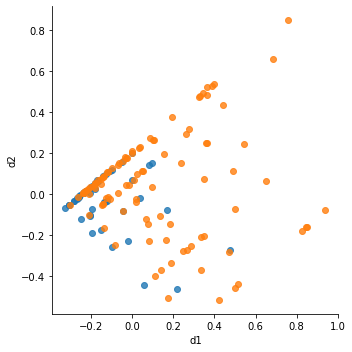

In [39]:
pca =PCA(n_components=2)
Xp = pd.DataFrame(pca.fit_transform(Xs),columns=['d1','d2'])
print(f'explained_variance_ratio:{pca.explained_variance_ratio_.cumsum()}')
print(f'explained_variance_ratio_: {round(pca.explained_variance_ratio_.cumsum()[-1],4)*100}%')
Xp[tgt]=yt.to_list()
#Xp.sample(frac=.01).iplot(kind='scatter',mode='markers',x='d1',y='d2',hue=tgt)
sns.lmplot( x="d1", y="d2", data=Xp.sample(frac=.01), fit_reg=False, hue=tgt, legend=False)


In [40]:
fig = px.scatter(Xp.sample(frac=.01), x='d1', y='d2',      color=tgt)
fig.show()

### 3-D

In [41]:
pca =PCA(n_components=3)
Xp = pd.DataFrame(pca.fit_transform(Xs),columns=['d1','d2','d3'])
print(f'explained_variance_ratio:{pca.explained_variance_ratio_.cumsum()}')
print(f'explained_variance_ratio_: {round(pca.explained_variance_ratio_.cumsum()[-1],4)*100}%')
Xp[tgt]=yt.to_list()


explained_variance_ratio:[0.29178632 0.4883867  0.64366149]
explained_variance_ratio_: 64.37%


In [42]:
fig = px.scatter_3d(Xp.sample(frac=.01), x='d1', y='d2', z='d3',
              color=tgt)
fig.show()

## Save imputer missings and scaler

In [44]:
pickle.dump(im, open('../transforms/imputer_missing.pkl', 'wb'))
pickle.dump(sc, open('../transforms/sc.pkl', 'wb'))

# Model

## Libraries

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV



## Define function to train  with randomized serch and cross validation to get the best model of this random selection and get metrics

In [54]:
def display_confusion_matrix(y_true, y_pred):
    display(confusion_matrix(y_true, y_pred))
    sns.set_theme(style='white')
    cm = confusion_matrix(y_true, y_pred, normalize='all')
    cmd = ConfusionMatrixDisplay(cm, )
    cmd.plot()
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Blues')  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    
def train_(param,model,Xt,Xv,Xval,yt,yv,yval):
    grid = RandomizedSearchCV(param_distributions=param,
                              n_jobs=-1,
                              n_iter=50,
                              cv=3,
                              estimator=model,
                              scoring='roc_auc')
    grid.fit(Xt,yt)

    print(f"Best parameters set found on development set:\n\n{grid.best_params_}")
    print(f"Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    aux_scores=pd.DataFrame([[mean,std,params] for mean,std,params in
                           zip(means,stds,grid.cv_results_['params'])],
                           columns=['mean','std','params'])
    aux_scores['model']=str(model)
    display(aux_scores)
    print("Detailed classification report:\n")
    ytrue,ypred=yt,grid.predict(Xt)
    print(classification_report(ytrue,ypred))
    aux_m=pd.DataFrame(classification_report(ytrue,ypred, output_dict=True))
    aux_m=pd.DataFrame([aux_m.T.to_numpy().flatten()],columns=[str(x)+'_'+str(y) for y in aux_m.columns for x in aux_m.index])
    aux_m['train']=round(roc_auc_score(y_true=yt,y_score=grid.best_estimator_.predict_proba(Xt)[:,1]),3)
    aux_m['test']=round(roc_auc_score(y_true=yv,y_score=grid.best_estimator_.predict_proba(Xv)[:,1]),3)
    aux_m['val']=round(roc_auc_score(y_true=yval,y_score=grid.best_estimator_.predict_proba(Xval)[:,1]),3)
    aux_m['model']=str(grid.best_estimator_)
    aux_m['params']=[grid.best_params_]
    
    display(aux_m)
    
    print('Train')
    y_true, y_pred = yt, grid.predict(Xt)
    display_confusion_matrix(y_true, y_pred)
    print('Test')
    y_true, y_pred = yv, grid.predict(Xv)
    display_confusion_matrix(y_true, y_pred)
    print('Val')
    y_true, y_pred = yval, grid.predict(Xval)
    display_confusion_matrix(y_true, y_pred)
    
    return grid.best_estimator_,grid.best_score_,grid.best_params_,aux_scores,aux_m

In [47]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def display_roc_(model,Xt,Xv,yt,yv):
    logit_roc_auc_t = roc_auc_score(yt, model.predict_proba(Xt)[:,1])
    fpr_t, tpr_t, thresholds_t = roc_curve(yt, model.predict_proba(Xt)[:,1])
    logit_roc_auc = roc_auc_score(yv, model.predict_proba(Xv)[:,1])
    fpr, tpr, thresholds = roc_curve(yv, model.predict_proba(Xv)[:,1])
    plt.figure()
    plt.plot(fpr_t, tpr_t, label=f'(area train= {round(logit_roc_auc_t,4)})')
    plt.plot(fpr, tpr, label=f'(area train= {round(logit_roc_auc,4)})')

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig(f'Log_ROC_'+str(model).split('(')[0]+'.jpg')
    display(plt.show())
def display_roc(model,Xt,Xv,Xval,yt,yv,yval):

    # Create an empty figure, and iteratively add new lines
    # every time we compute a new class
    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )
    #train
    y_true = yt
    y_score = model.predict_proba(Xt)[:,1]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)
    name = f"Train (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))
    #test
    y_true = yv
    y_score = model.predict_proba(Xv)[:,1]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)
    name = f"Test (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))
    #val
    y_true = yval
    y_score = model.predict_proba(Xval)[:,1]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)
    name = f"VAL (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))
    
    fig.update_layout(
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=700, height=500,
        legend=dict(
    #orientation="h",
    yanchor="bottom",
    y=.02,
    xanchor="right",
    x=.75
)
        
    )
    
    fig.show()

In [48]:
df_metrics=pd.DataFrame()
df_scores=pd.DataFrame()

## Logistic Regression

In [49]:
yt.value_counts(normalize=1)

1    0.583323
0    0.416677
Name: NOT_NORM, dtype: float64

In [50]:
dc_feat

{'dates': ['recording_date'],
 'lists': [],
 'texts': [],
 'ids': ['ecg_id', 'patient_id', 'filename_lr', 'filename_hr', 'file_name'],
 'target': 'NOT_NORM',
 'continuous': ['III_yP_yS',
  'V5_yP_yT',
  'bin_I_tP_tS_woe',
  'III_yP_yQ',
  'bin_V1_yP_yQ_woe',
  'II_yQ_yR',
  'bin_V3_yP_yT_woe',
  'bin_V5_yP_yQ_woe',
  'bin_V2_tR_tS_woe',
  'V3_tP_tQ',
  'II_tS_tT',
  'II_tP_tQ',
  'bin_V5_yR_yS_woe',
  'V1_tQ_tS'],
 'discretes': ['bin_V5_yP_yT',
  'bin_V1_yP_yQ',
  'bin_II_yP_yT',
  'bin_III_yP_yS',
  'bin_I_yQ_yT',
  'bin_II_yP_yS',
  'bin_II_yQ_yR',
  'bin_I_tP_tS',
  'bin_AVL_tQ_tS',
  'bin_V5_yR_yS',
  'bin_V2_yP_yR',
  'bin_V1_tQ_tS',
  'bin_II_tQ_tR',
  'bin_V4_yR_yT',
  'bin_III_yP_yQ',
  'bin_V2_tR_tT',
  'bin_AVR_yR_yT',
  'bin_V3_tP_tQ',
  'bin_V5_yP_yQ',
  'bin_II_tS_tT',
  'bin_II_tP_tQ',
  'bin_V2_tR_tS',
  'bin_V3_yP_yT',
  'bin_I_tS_tT']}

/media/dbh/Seagate Expansion Drive/dbh/Maestría tecnología avanzada/envs/cardiovascular_patterns/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning:

The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.



Best parameters set found on development set:

{'random_state': 92}
Grid scores on development set:



mean       std                params                 model
0  0.882576  0.007035  {'random_state': 92}  LogisticRegression()

Detailed classification report:

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      6551
           1       0.84      0.82      0.83      9171

    accuracy                           0.80     15722
   macro avg       0.80      0.80      0.80     15722
weighted avg       0.80      0.80      0.80     15722



precision_0  recall_0  f1-score_0  support_0  precision_1  recall_1  \
0     0.755314  0.775607    0.765326     6551.0     0.836576  0.820521   

   f1-score_1  support_1  precision_accuracy  recall_accuracy  \
0    0.828471     9171.0            0.801806         0.801806   

   f1-score_accuracy  support_accuracy  precision_macro avg  recall_macro avg  \
0           0.801806          0.801806             0.795945          0.798064   

   f1-score_macro avg  support_macro avg  precision_weighted avg  \
0            0.796898            15722.0                0.802716   

   recall_weighted avg  f1-score_weighted avg  support_weighted avg  train  \
0             0.801806                0.80216               15722.0  0.883   

    test    val                                model                params  
0  0.876  0.867  LogisticRegression(random_state=92)  {'random_state': 92}

Train


array([[5081, 1470],
       [1646, 7525]])

Test


array([[1292,  352],
       [ 440, 1847]])

Val


array([[ 702,  222],
       [ 246, 1014]])

CPU times: user 1.85 s, sys: 5.05 s, total: 6.91 s
Wall time: 1.69 s


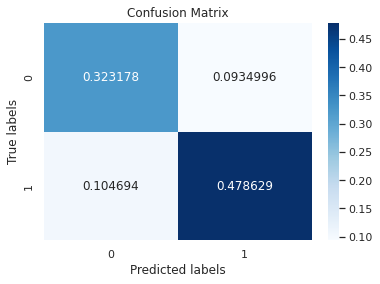

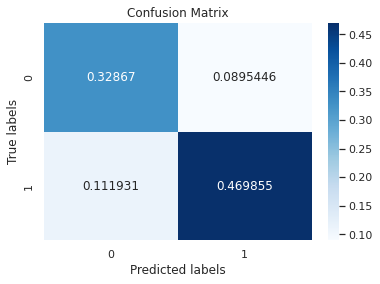

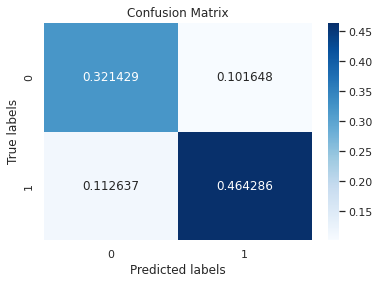

In [55]:
%%time
model = LogisticRegression()
param = dict(random_state=[int(np.random.uniform(0,1000))])
model,score,params,scores,metrics = train_(param,model,Xt,Xv,Xval,yt,yv,yval)
display_roc(model,Xt,Xv,Xval,yt,yv,yval)
df_metrics=pd.concat([df_metrics,metrics])
df_scores=pd.concat([df_scores,scores])

## Random Forest

In [56]:
param = dict(n_estimators = range(2,20), 
max_depth = range(2,10),
random_state= np.random.uniform(0,1000,100).astype(int),
max_features = range(2,len(dc_feat['continuous'])),
criterion = ['gini','entropy'])

Best parameters set found on development set:

{'random_state': 153, 'n_estimators': 17, 'max_features': 3, 'max_depth': 8, 'criterion': 'gini'}
Grid scores on development set:



mean       std                                             params  \
0   0.792315  0.003407  {'random_state': 826, 'n_estimators': 7, 'max_...   
1   0.899112  0.005020  {'random_state': 2, 'n_estimators': 13, 'max_f...   
2   0.884224  0.003964  {'random_state': 114, 'n_estimators': 4, 'max_...   
3   0.886291  0.006041  {'random_state': 854, 'n_estimators': 8, 'max_...   
4   0.896269  0.004194  {'random_state': 675, 'n_estimators': 10, 'max...   
5   0.887291  0.004951  {'random_state': 610, 'n_estimators': 17, 'max...   
6   0.883012  0.003231  {'random_state': 30, 'n_estimators': 14, 'max_...   
7   0.886183  0.004118  {'random_state': 582, 'n_estimators': 3, 'max_...   
8   0.877052  0.006398  {'random_state': 977, 'n_estimators': 3, 'max_...   
9   0.896552  0.004647  {'random_state': 739, 'n_estimators': 7, 'max_...   
10  0.837436  0.009075  {'random_state': 110, 'n_estimators': 2, 'max_...   
11  0.886891  0.003171  {'random_state': 89, 'n_estimators': 7, 'max_f...   
12  0.876721  0.004047  {'random_state': 686, 'n_estimators': 9, 'max_...   
13  0.883515  0.002558  {'random_state': 903, 'n_estimators': 19, 'max...   
14  0.872260  0.003748  {'random_state': 234, 'n_estimators': 18, 'max...   
15  0.877481  0.006320  {'random_state': 110, 'n_estimators': 16, 'max...   
16  0.892551  0.006485  {'random_state': 449, 'n_estimators': 10, 'max...   
17  0.790126  0.003185  {'random_state': 114, 'n_estimators': 2, 'max_...   
18  0.889455  0.003723  {'random_state': 977, 'n_estimators': 8, 'max_...   
19  0.883912  0.003976  {'random_state': 144, 'n_estimators': 17, 'max...   
20  0.886303  0.003369  {'random_state': 324, 'n_estimators': 13, 'max...   
21  0.894924  0.003054  {'random_state': 675, 'n_estimators': 15, 'max...   
22  0.897358  0.003564  {'random_state': 200, 'n_estimators': 13, 'max...   
23  0.902403  0.004082  {'random_state': 448, 'n_estimators': 17, 'max...   
24  0.860408  0.006709  {'random_state': 631, 'n_estimators': 9, 'max_...   
25  0.815722  0.005675  {'random_state': 921, 'n_estimators': 3, 'max_...   
26  0.893132  0.005014  {'random_state': 296, 'n_estimators': 16, 'max...   
27  0.821781  0.002890  {'random_state': 288, 'n_estimators': 7, 'max_...   
28  0.890516  0.003800  {'random_state': 589, 'n_estimators': 16, 'max...   
29  0.834216  0.006887  {'random_state': 550, 'n_estimators': 6, 'max_...   
30  0.902987  0.005364  {'random_state': 153, 'n_estimators': 17, 'max...   
31  0.873332  0.001915  {'random_state': 430, 'n_estimators': 2, 'max_...   
32  0.901822  0.004090  {'random_state': 94, 'n_estimators': 16, 'max_...   
33  0.854221  0.004315  {'random_state': 693, 'n_estimators': 2, 'max_...   
34  0.899217  0.004828  {'random_state': 692, 'n_estimators': 14, 'max...   
35  0.888592  0.003488  {'random_state': 370, 'n_estimators': 16, 'max...   
36  0.885071  0.005071  {'random_state': 740, 'n_estimators': 19, 'max...   
37  0.872258  0.002002  {'random_state': 360, 'n_estimators': 9, 'max_...   
38  0.895256  0.005056  {'random_state': 153, 'n_estimators': 7, 'max_...   
39  0.839861  0.002790  {'random_state': 686, 'n_estimators': 5, 'max_...   
40  0.892323  0.005276  {'random_state': 624, 'n_estimators': 13, 'max...   
41  0.895102  0.003606  {'random_state': 503, 'n_estimators': 10, 'max...   
42  0.880283  0.005028  {'random_state': 237, 'n_estimators': 18, 'max...   
43  0.889538  0.005315  {'random_state': 921, 'n_estimators': 19, 'max...   
44  0.857351  0.007448  {'random_state': 949, 'n_estimators': 14, 'max...   
45  0.889606  0.003999  {'random_state': 114, 'n_estimators': 17, 'max...   
46  0.896525  0.004428  {'random_state': 89, 'n_estimators': 15, 'max_...   
47  0.899035  0.005296  {'random_state': 433, 'n_estimators': 19, 'max...   
48  0.849618  0.003664  {'random_state': 876, 'n_estimators': 10, 'max...   
49  0.889142  0.003821  {'random_state': 423, 'n_estimators': 18, 'max...   

                       model  
0   RandomForestClassifier()  
1   RandomForestCl

Detailed classification report:

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      6551
           1       0.89      0.85      0.87      9171

    accuracy                           0.85     15722
   macro avg       0.84      0.85      0.85     15722
weighted avg       0.85      0.85      0.85     15722



precision_0  recall_0  f1-score_0  support_0  precision_1  recall_1  \
0     0.799311  0.850557    0.824138     6551.0     0.888127  0.847454   

   f1-score_1  support_1  precision_accuracy  recall_accuracy  \
0    0.867314     9171.0            0.848747         0.848747   

   f1-score_accuracy  support_accuracy  precision_macro avg  recall_macro avg  \
0           0.848747          0.848747             0.843719          0.849006   

   f1-score_macro avg  support_macro avg  precision_weighted avg  \
0            0.845726            15722.0                 0.85112   

   recall_weighted avg  f1-score_weighted avg  support_weighted avg  train  \
0             0.848747               0.849324               15722.0  0.925   

    test    val                                              model  \
0  0.906  0.895  RandomForestClassifier(max_depth=8, max_featur...   

                                              params  
0  {'random_state': 153, 'n_estimators': 17, 'max...

Train


array([[5572,  979],
       [1399, 7772]])

Test


array([[1372,  272],
       [ 383, 1904]])

Val


array([[ 745,  179],
       [ 211, 1049]])

CPU times: user 1.27 s, sys: 341 ms, total: 1.62 s
Wall time: 5.28 s


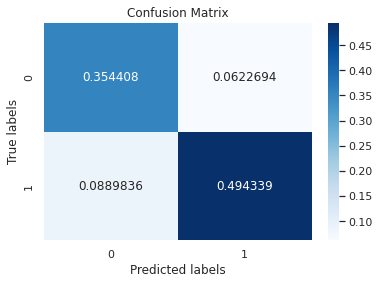

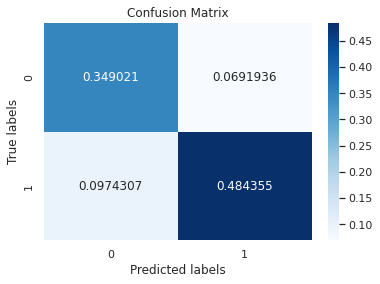

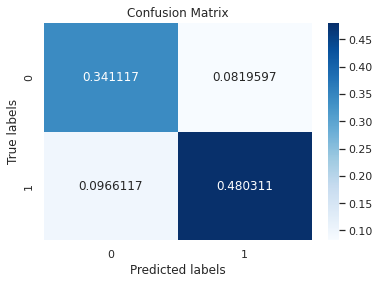

In [57]:
%%time
model = RandomForestClassifier()
model,score,params,scores,metrics = train_(param,model,Xt,Xv,Xval,yt,yv,yval)
display_roc(model,Xt,Xv,Xval,yt,yv,yval)
df_metrics=pd.concat([df_metrics,metrics])
df_scores=pd.concat([df_scores,scores])

## Red neural

In [58]:
# param = dict(hidden_layer_sizes=[(a,b,c, ) for a in range(len(dc_feat['continuous']),len(dc_feat['continuous'])*2) for b in range(len(dc_feat['continuous']),len(dc_feat['continuous'])*2) for c in range(len(dc_feat['continuous']),len(dc_feat['continuous'])*2)],
#              activation = ['identity', 'logistic', 'tanh', 'relu'],
#              solver = ['lbfgs', 'sgd', 'adam'],
#              alpha = np.arange(0.0001,0.001,0.0001),
#              learning_rate = ['constant', 'invscaling', 'adaptive']
#             )

In [59]:
# %%time
# model = MLPClassifier()
# model,score,params,scores,metrics = train_(param,model,Xt,Xv,yt,yv)


##  ADABoost

In [60]:
param = dict(max_depth=range(1,10,1),
             learning_rate=np.arange(.01,.1,.01),
             random_state= np.random.uniform(0,1000,100).astype(int),
             booster=['gbtree','gblinear','dart'],
             tree_method =['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
             sketch_eps=np.arange(.01,.1,.01),
#              updater=['grow_colmaker','grow_histmaker','grow_local_histmaker',
#                       'grow_skmaker','grow_quantile_histmaker','grow_gpu_hist',
#                       'sync','refresh','prune'],
            )

Best parameters set found on development set:

{'n_estimators': 19, 'learning_rate': 0.40000000000000013, 'algorithm': 'SAMME.R'}
Grid scores on development set:



mean       std                                             params  \
0   0.786559  0.003843  {'n_estimators': 3, 'learning_rate': 0.3000000...   
1   0.821337  0.002782  {'n_estimators': 5, 'learning_rate': 0.2500000...   
2   0.834625  0.000247  {'n_estimators': 18, 'learning_rate': 0.200000...   
3   0.853289  0.005652  {'n_estimators': 11, 'learning_rate': 0.750000...   
4   0.721085  0.013218  {'n_estimators': 3, 'learning_rate': 0.1, 'alg...   
5   0.863756  0.004704  {'n_estimators': 10, 'learning_rate': 0.300000...   
6   0.725087  0.015598  {'n_estimators': 9, 'learning_rate': 0.1, 'alg...   
7   0.837777  0.003079  {'n_estimators': 10, 'learning_rate': 0.1, 'al...   
8   0.884456  0.005182  {'n_estimators': 13, 'learning_rate': 0.900000...   
9   0.847667  0.008163  {'n_estimators': 17, 'learning_rate': 0.300000...   
10  0.852287  0.005248  {'n_estimators': 8, 'learning_rate': 0.3000000...   
11  0.889213  0.005233  {'n_estimators': 16, 'learning_rate': 0.500000...   
12  0.854510  0.008449  {'n_estimators': 15, 'learning_rate': 0.500000...   
13  0.766962  0.038217  {'n_estimators': 15, 'learning_rate': 0.1, 'al...   
14  0.888868  0.004624  {'n_estimators': 19, 'learning_rate': 0.300000...   
15  0.880225  0.003425  {'n_estimators': 17, 'learning_rate': 0.250000...   
16  0.811839  0.006655  {'n_estimators': 12, 'learning_rate': 0.200000...   
17  0.832265  0.006975  {'n_estimators': 6, 'learning_rate': 0.9500000...   
18  0.890060  0.004587  {'n_estimators': 16, 'learning_rate': 0.850000...   
19  0.881314  0.004135  {'n_estimators': 15, 'learning_rate': 0.300000...   
20  0.849127  0.006447  {'n_estimators': 11, 'learning_rate': 0.650000...   
21  0.890540  0.004646  {'n_estimators': 16, 'learning_rate': 0.650000...   
22  0.869956  0.002630  {'n_estimators': 9, 'learning_rate': 0.8000000...   
23  0.843278  0.004631  {'n_estimators': 8, 'learning_rate': 0.8500000...   
24  0.726943  0.014713  {'n_estimators': 9, 'learning_rate': 0.1500000...   
25  0.848672  0.005535  {'n_estimators': 12, 'learning_rate': 0.600000...   
26  0.851729  0.006807  {'n_estimators': 12, 'learning_rate': 0.650000...   
27  0.854050  0.006068  {'n_estimators': 11, 'learning_rate': 0.850000...   
28  0.722861  0.016949  {'n_estimators': 4, 'learning_rate': 0.3000000...   
29  0.820125  0.003665  {'n_estimators': 4, 'learning_rate': 0.5500000...   
30  0.792052  0.005617  {'n_estimators': 11, 'learning_rate': 0.150000...   
31  0.863052  0.005612  {'n_estimators': 19, 'learning_rate': 0.700000...   
32  0.860398  0.004473  {'n_estimators': 16, 'learning_rate': 0.700000...   
33  0.876650  0.004525  {'n_estimators': 10, 'learning_rate': 0.600000...   
34  0.862287  0.005288  {'n_estimators': 18, 'learning_rate': 0.650000...   
35  0.864346  0.004797  {'n_estimators': 17, 'learning_rate': 0.800000...   
36  0.837537  0.005835  {'n_estimators': 11, 'learning_rate': 0.400000...   
37  0.875255  0.004848  {'n_estimators': 12, 'learning_rate': 0.350000...   
38  0.812414  0.002148  {'n_estimators': 3, 'learning_rate': 0.8000000...   
39  0.703437  0.002344  {'n_estimators': 2, 'learning_rate': 0.6500000...   
40  0.860553  0.004654  {'n_estimators': 7, 'learning_rate': 0.9500000...   
41  0.787549  0.002113  {'n_estimators': 6, 'learning_rate': 0.3000000...   
42  0.792340  0.012228  {'n_estimators': 4, 'learning_rate': 0.8500000...   
43  0.892320  0.004332  {'n_estimators': 19, 'learning_rate': 0.400000...   
44  0.851720  0.002972  {'n_estimators': 6, 'learning_rate': 0.7500000...   
45  0.884484  0.005632  {'n_estimators': 13, 'learning_rate': 0.800000...   
46  0.703437  0.002344  {'n_estimators': 2, 'learning_rate': 0.9500000...   
47  0.860238  0.004645  {'n_estimators': 9, 'learning_rate': 0.2500000...   
48  0.780742  0.004288  {'n_estimators': 4, 'learning_rate': 0.7000000...   
49  0.810423  0.008141  {'n_estimators': 7, 'learning_rate': 0.1, 'alg...   

                   model  
0   AdaBoostClassifier()  
1   AdaBoostClassifier()  

Detailed classification report:

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      6551
           1       0.86      0.82      0.84      9171

    accuracy                           0.82     15722
   macro avg       0.81      0.82      0.81     15722
weighted avg       0.82      0.82      0.82     15722



precision_0  recall_0  f1-score_0  support_0  precision_1  recall_1  \
0     0.763706  0.816517    0.789229     6551.0     0.862124   0.81954   

   f1-score_1  support_1  precision_accuracy  recall_accuracy  \
0    0.840293     9171.0             0.81828          0.81828   

   f1-score_accuracy  support_accuracy  precision_macro avg  recall_macro avg  \
0            0.81828           0.81828             0.812915          0.818028   

   f1-score_macro avg  support_macro avg  precision_weighted avg  \
0            0.814761            15722.0                0.821116   

   recall_weighted avg  f1-score_weighted avg  support_weighted avg  train  \
0              0.81828               0.819016               15722.0  0.897   

    test    val                                              model  \
0  0.895  0.884  AdaBoostClassifier(learning_rate=0.40000000000...   

                                              params  
0  {'n_estimators': 19, 'learning_rate': 0.400000...

Train


array([[5349, 1202],
       [1655, 7516]])

Test


array([[1348,  296],
       [ 422, 1865]])

Val


array([[ 738,  186],
       [ 235, 1025]])

CPU times: user 1.1 s, sys: 370 ms, total: 1.47 s
Wall time: 2.71 s


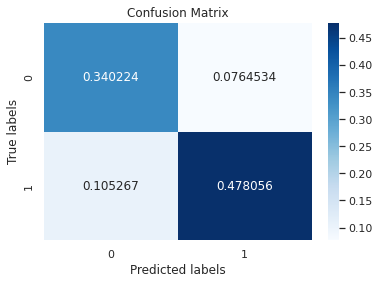

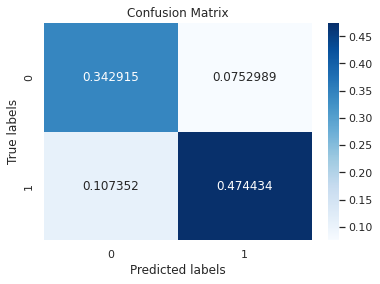

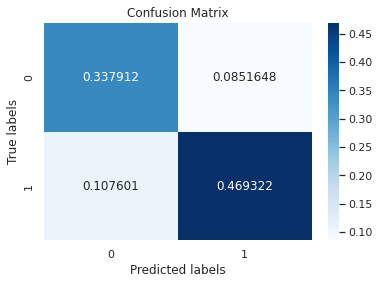

In [61]:
%%time
param = dict(n_estimators = range(2,20),
             learning_rate=np.arange(0.1,1,0.05),
             algorithm = ['SAMME', 'SAMME.R'])
model = AdaBoostClassifier()
model,score,params,scores,metrics = train_(param,model,Xt,Xv,Xval,yt,yv,yval)
display_roc(model,Xt,Xv,Xval,yt,yv,yval)
df_metrics=pd.concat([df_metrics,metrics])
df_scores=pd.concat([df_scores,scores])

## XGBC

/media/dbh/Seagate Expansion Drive/dbh/Maestría tecnología avanzada/envs/cardiovascular_patterns/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[17:56:56] WARNING: ../src/learner.cc:576: 
Parameters: { "algorithm" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:56:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:

{'n_estimators': 19, 'learning_rate': 0.3500000000000001, 'algorithm': 'SAMME.R'}
Grid scores on development set:



mean       std                                             params  \
0   0.904720  0.003327  {'n_estimators': 8, 'learning_rate': 0.4500000...   
1   0.897797  0.002952  {'n_estimators': 16, 'learning_rate': 0.750000...   
2   0.895580  0.003618  {'n_estimators': 10, 'learning_rate': 0.900000...   
3   0.897841  0.003373  {'n_estimators': 15, 'learning_rate': 0.800000...   
4   0.895555  0.005221  {'n_estimators': 5, 'learning_rate': 0.3000000...   
5   0.881122  0.005306  {'n_estimators': 2, 'learning_rate': 0.9500000...   
6   0.899149  0.004642  {'n_estimators': 12, 'learning_rate': 0.800000...   
7   0.900850  0.002459  {'n_estimators': 10, 'learning_rate': 0.700000...   
8   0.905062  0.003794  {'n_estimators': 18, 'learning_rate': 0.500000...   
9   0.897721  0.003245  {'n_estimators': 17, 'learning_rate': 0.750000...   
10  0.898266  0.004480  {'n_estimators': 5, 'learning_rate': 0.6000000...   
11  0.890497  0.002908  {'n_estimators': 3, 'learning_rate': 0.6500000...   
12  0.906793  0.003445  {'n_estimators': 12, 'learning_rate': 0.450000...   
13  0.900242  0.004138  {'n_estimators': 11, 'learning_rate': 0.150000...   
14  0.902660  0.003785  {'n_estimators': 8, 'learning_rate': 0.6000000...   
15  0.894695  0.004204  {'n_estimators': 8, 'learning_rate': 0.1500000...   
16  0.891725  0.005211  {'n_estimators': 4, 'learning_rate': 0.3000000...   
17  0.905214  0.003376  {'n_estimators': 16, 'learning_rate': 0.550000...   
18  0.881606  0.005222  {'n_estimators': 2, 'learning_rate': 0.8500000...   
19  0.893143  0.004298  {'n_estimators': 10, 'learning_rate': 0.1, 'al...   
20  0.895768  0.004428  {'n_estimators': 5, 'learning_rate': 0.9000000...   
21  0.899317  0.005691  {'n_estimators': 8, 'learning_rate': 0.8000000...   
22  0.901614  0.004537  {'n_estimators': 7, 'learning_rate': 0.3000000...   
23  0.902377  0.003606  {'n_estimators': 8, 'learning_rate': 0.5000000...   
24  0.897973  0.003802  {'n_estimators': 14, 'learning_rate': 0.1, 'al...   
25  0.905980  0.003799  {'n_estimators': 17, 'learning_rate': 0.150000...   
26  0.896188  0.004154  {'n_estimators': 6, 'learning_rate': 0.8500000...   
27  0.901023  0.002174  {'n_estimators': 7, 'learning_rate': 0.6500000...   
28  0.893199  0.003330  {'n_estimators': 9, 'learning_rate': 0.9500000...   
29  0.880430  0.003754  {'n_estimators': 2, 'learning_rate': 0.4500000...   
30  0.906659  0.003232  {'n_estimators': 10, 'learning_rate': 0.450000...   
31  0.908465  0.002376  {'n_estimators': 18, 'learning_rate': 0.350000...   
32  0.893407  0.005534  {'n_estimators': 17, 'learning_rate': 0.850000...   
33  0.904899  0.003519  {'n_estimators': 17, 'learning_rate': 0.550000...   
34  0.899329  0.003585  {'n_estimators': 6, 'learning_rate': 0.7500000...   
35  0.908592  0.002578  {'n_estimators': 19, 'learning_rate': 0.350000...   
36  0.892577  0.003250  {'n_estimators': 13, 'learning_rate': 0.950000...   
37  0.886673  0.003648  {'n_estimators': 6, 'learning_rate': 0.1, 'alg...   
38  0.889352  0.003554  {'n_estimators': 19, 'learning_rate': 0.950000...   
39  0.903217  0.003729  {'n_estimators': 14, 'learning_rate': 0.150000...   
40  0.908346  0.004016  {'n_estimators': 14, 'learning_rate': 0.300000...   
41  0.902943  0.003827  {'n_estimators': 8, 'learning_rate': 0.5500000...   
42  0.899875  0.002631  {'n_estimators': 13, 'learning_rate': 0.700000...   
43  0.879165  0.003861  {'n_estimators': 3, 'learning_rate': 0.1500000...   
44  0.887947  0.004650  {'n_estimators': 5, 'learning_rate': 0.1500000...   
45  0.888645  0.004456  {'n_estimators': 3, 'learning_rate': 0.9500000...   
46  0.880650  0.003131  {'n_estimators': 2, 'learning_rate': 0.5000000...   
47  0.873876  0.004319  {'n_estimators': 2, 'learning_rate': 0.2000000...   
48  0.905755  0.003321  {'n_estimators': 9, 'learning_rate': 0.4500000...   
49  0.891443  0.004531  {'n_estimators': 9, 'learning_rate': 0.1, 'alg...   

                                                model  
0   XGBClassifier(base_s

Detailed classification report:

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      6551
           1       0.91      0.88      0.89      9171

    accuracy                           0.88     15722
   macro avg       0.87      0.88      0.87     15722
weighted avg       0.88      0.88      0.88     15722



precision_0  recall_0  f1-score_0  support_0  precision_1  recall_1  \
0     0.834616  0.877423    0.855484     6551.0     0.909111  0.875804   

   f1-score_1  support_1  precision_accuracy  recall_accuracy  \
0    0.892147     9171.0            0.876479         0.876479   

   f1-score_accuracy  support_accuracy  precision_macro avg  recall_macro avg  \
0           0.876479          0.876479             0.871864          0.876614   

   f1-score_macro avg  support_macro avg  precision_weighted avg  \
0            0.873816            15722.0                0.878071   

   recall_weighted avg  f1-score_weighted avg  support_weighted avg  train  \
0             0.876479               0.876871               15722.0  0.946   

    test    val                                              model  \
0  0.909  0.906  XGBClassifier(algorithm='SAMME.R', base_score=...   

                                              params  
0  {'n_estimators': 19, 'learning_rate': 0.350000...

Train


array([[5748,  803],
       [1139, 8032]])

Test


array([[1361,  283],
       [ 369, 1918]])

Val


array([[ 752,  172],
       [ 198, 1062]])

CPU times: user 5.13 s, sys: 537 ms, total: 5.66 s
Wall time: 1min 12s


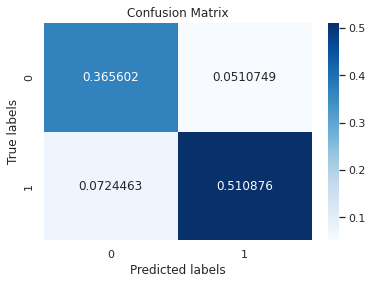

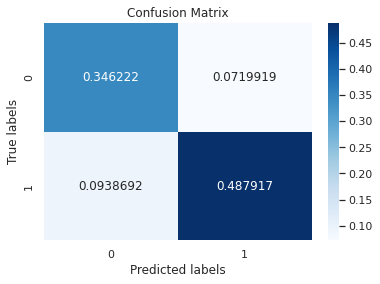

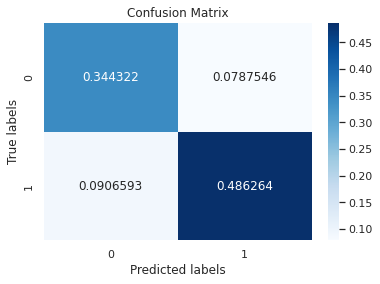

In [62]:
%%time
model = XGBClassifier()
model,score,params,scores,metrics = train_(param,model,Xt,Xv,Xval,yt,yv,yval)
display_roc(model,Xt,Xv,Xval,yt,yv,yval)
df_metrics=pd.concat([df_metrics,metrics])
df_scores=pd.concat([df_scores,scores])

In [111]:
df_scores.sort_values('mean',ascending=False)

mean       std                                             params  \
4   0.891321  0.003220  {'n_estimators': 15, 'learning_rate': 0.300000...   
18  0.890989  0.003358  {'n_estimators': 17, 'learning_rate': 0.250000...   
7   0.890246  0.002921  {'n_estimators': 17, 'learning_rate': 0.200000...   
41  0.889845  0.002972  {'n_estimators': 17, 'learning_rate': 0.400000...   
31  0.889545  0.003394  {'n_estimators': 16, 'learning_rate': 0.500000...   
..       ...       ...                                                ...   
15  0.715558  0.003246  {'n_estimators': 2, 'learning_rate': 0.6000000...   
6   0.715528  0.003230  {'n_estimators': 2, 'learning_rate': 0.6500000...   
20  0.715115  0.003356  {'n_estimators': 3, 'learning_rate': 0.7500000...   
26  0.714613  0.003611  {'n_estimators': 3, 'learning_rate': 0.6500000...   
39  0.711281  0.005112  {'n_estimators': 4, 'learning_rate': 0.1, 'alg...   

                                                model  
4   XGBClassifier(base_score=None, booster=None, c...  
18  XGBClassifier(base_score=None, booster=None, c...  
7   XGBClassifier(base_score=None, booster=None, c...  
41  XGBClassifier(base_score=None, booster=None, c...  
31  XGBClassifier(base_score=None, booster=None, c...  
..                                                ...  
15                               AdaBoostClassifier()  
6                                AdaBoostClassifier()  
20                               AdaBoostClassifier()  
26                               AdaBoostClassifier()  
39                               AdaBoostClassifier()  

[151 rows x 4 columns]

In [99]:
df_metrics.columns

Index(['precision_0', 'recall_0', 'f1-score_0', 'support_0', 'precision_1',
       'recall_1', 'f1-score_1', 'support_1', 'precision_accuracy',
       'recall_accuracy', 'f1-score_accuracy', 'support_accuracy',
       'precision_macro avg', 'recall_macro avg', 'f1-score_macro avg',
       'support_macro avg', 'precision_weighted avg', 'recall_weighted avg',
       'f1-score_weighted avg', 'support_weighted avg', 'train', 'test', 'val',
       'model', 'params', 'model_', 'mean'],
      dtype='object')

In [63]:
df_metrics.sort_values('test',ascending=False)

precision_0  recall_0  f1-score_0  support_0  precision_1  recall_1  \
0     0.834616  0.877423    0.855484     6551.0     0.909111  0.875804   
0     0.799311  0.850557    0.824138     6551.0     0.888127  0.847454   
0     0.763706  0.816517    0.789229     6551.0     0.862124  0.819540   
0     0.755314  0.775607    0.765326     6551.0     0.836576  0.820521   
0     0.755314  0.775607    0.765326     6551.0     0.836576  0.820521   

   f1-score_1  support_1  precision_accuracy  recall_accuracy  \
0    0.892147     9171.0            0.876479         0.876479   
0    0.867314     9171.0            0.848747         0.848747   
0    0.840293     9171.0            0.818280         0.818280   
0    0.828471     9171.0            0.801806         0.801806   
0    0.828471     9171.0            0.801806         0.801806   

   f1-score_accuracy  support_accuracy  precision_macro avg  recall_macro avg  \
0           0.876479          0.876479             0.871864          0.876614   
0           0.848747          0.848747             0.843719          0.849006   
0           0.818280          0.818280             0.812915          0.818028   
0           0.801806          0.801806             0.795945          0.798064   
0           0.801806          0.801806             0.795945          0.798064   

   f1-score_macro avg  support_macro avg  precision_weighted avg  \
0            0.873816            15722.0                0.878071   
0            0.845726            15722.0                0.851120   
0            0.814761            15722.0                0.821116   
0            0.796898            15722.0                0.802716   
0            0.796898            15722.0                0.802716   

   recall_weighted avg  f1-score_weighted avg  support_weighted avg  train  \
0             0.876479               0.876871               15722.0  0.946   
0             0.848747               0.849324               15722.0  0.925   
0             0.818280               0.819016               15722.0  0.897   
0             0.801806               0.802160               15722.0  0.883   
0             0.801806               0.802160               15722.0  0.883   

    test    val                                              model  \
0  0.909  0.906  XGBClassifier(algorithm='SAMME.R', base_score=...   
0  0.906  0.895  RandomForestClassifier(max_depth=8, max_featur...   
0  0.895  0.884  AdaBoostClassifier(learning_rate=0.40000000000...   
0  0.876  0.867               LogisticRegression(random_state=884)   
0  0.876  0.867                LogisticRegression(random_state=92)   

                                              params  
0  {'n_estimators': 19, 'learning_rate': 0.350000...  
0  {'random_state': 153, 'n_estimators': 17, 'max...  
0  {'n_estimators': 19, 'learning_rate': 0.400000...  
0                              {'random_state': 884}  
0                               {'random_state': 92}

In [68]:
df_metrics['model_']=df_metrics['model'].map(lambda x: x.split('(')[0])
df_metrics['mean']=df_metrics[['train','test']].apply(np.mean,axis=1)
df_metrics[[x for x in df_metrics.columns if not 'support' in x] ].sort_values('mean').iplot(x='model_',kind='bar')

In [69]:
df_scores

mean       std                                             params  \
0   0.882576  0.007035                              {'random_state': 884}   
0   0.882576  0.007035                               {'random_state': 92}   
0   0.792315  0.003407  {'random_state': 826, 'n_estimators': 7, 'max_...   
1   0.899112  0.005020  {'random_state': 2, 'n_estimators': 13, 'max_f...   
2   0.884224  0.003964  {'random_state': 114, 'n_estimators': 4, 'max_...   
..       ...       ...                                                ...   
45  0.888645  0.004456  {'n_estimators': 3, 'learning_rate': 0.9500000...   
46  0.880650  0.003131  {'n_estimators': 2, 'learning_rate': 0.5000000...   
47  0.873876  0.004319  {'n_estimators': 2, 'learning_rate': 0.2000000...   
48  0.905755  0.003321  {'n_estimators': 9, 'learning_rate': 0.4500000...   
49  0.891443  0.004531  {'n_estimators': 9, 'learning_rate': 0.1, 'alg...   

                                                model  
0                                LogisticRegression()  
0                                LogisticRegression()  
0                            RandomForestClassifier()  
1                            RandomForestClassifier()  
2                            RandomForestClassifier()  
..                                                ...  
45  XGBClassifier(base_score=None, booster=None, c...  
46  XGBClassifier(base_score=None, booster=None, c...  
47  XGBClassifier(base_score=None, booster=None, c...  
48  XGBClassifier(base_score=None, booster=None, c...  
49  XGBClassifier(base_score=None, booster=None, c...  

[152 rows x 4 columns]

In [70]:
df_scores['params']=df_scores['params'].astype(str)
df_scores['model_']=df_scores['model'].map(lambda x: x.split('(')[0])

In [71]:

df_scores.reset_index(drop=True,inplace=True)

aux=df_scores.groupby(['model_','params']).agg({'mean':'mean'}).sort_values('mean').reset_index()
aux['k'] = aux.groupby('model_').cumcount()+1
aux.pivot_table(index='k',values='mean',columns='model_').ffill().iplot()

In [72]:
df_scores.pivot_table(values='mean',columns='model_',index='params')

model_                                              AdaBoostClassifier  \
params                                                                   
{'n_estimators': 10, 'learning_rate': 0.1, 'alg...            0.837777   
{'n_estimators': 10, 'learning_rate': 0.3000000...            0.863756   
{'n_estimators': 10, 'learning_rate': 0.4500000...                 NaN   
{'n_estimators': 10, 'learning_rate': 0.6000000...            0.876650   
{'n_estimators': 10, 'learning_rate': 0.7000000...                 NaN   
...                                                                ...   
{'random_state': 92}                                               NaN   
{'random_state': 94, 'n_estimators': 16, 'max_f...                 NaN   
{'random_state': 949, 'n_estimators': 14, 'max_...                 NaN   
{'random_state': 977, 'n_estimators': 3, 'max_f...                 NaN   
{'random_state': 977, 'n_estimators': 8, 'max_f...                 NaN   

model_                                              LogisticRegression  \
params                                                                   
{'n_estimators': 10, 'learning_rate': 0.1, 'alg...                 NaN   
{'n_estimators': 10, 'learning_rate': 0.3000000...                 NaN   
{'n_estimators': 10, 'learning_rate': 0.4500000...                 NaN   
{'n_estimators': 10, 'learning_rate': 0.6000000...                 NaN   
{'n_estimators': 10, 'learning_rate': 0.7000000...                 NaN   
...                                                                ...   
{'random_state': 92}                                          0.882576   
{'random_state': 94, 'n_estimators': 16, 'max_f...                 NaN   
{'random_state': 949, 'n_estimators': 14, 'max_...                 NaN   
{'random_state': 977, 'n_estimators': 3, 'max_f...                 NaN   
{'random_state': 977, 'n_estimators': 8, 'max_f...                 NaN   

model_                                              RandomForestClassifier  \
params                                                                       
{'n_estimators': 10, 'learning_rate': 0.1, 'alg...                     NaN   
{'n_estimators': 10, 'learning_rate': 0.3000000...                     NaN   
{'n_estimators': 10, 'learning_rate': 0.4500000...                     NaN   
{'n_estimators': 10, 'learning_rate': 0.6000000...                     NaN   
{'n_estimators': 10, 'learning_rate': 0.7000000...                     NaN   
...                                                                    ...   
{'random_state': 92}                                                   NaN   
{'random_state': 94, 'n_estimators': 16, 'max_f...                0.901822   
{'random_state': 949, 'n_estimators': 14, 'max_...                0.857351   
{'random_state': 977, 'n_estimators': 3, 'max_f...                0.877052   
{'random_state': 977, 'n_estimators': 8, 'max_f...                0.889455   

model_                                              XGBClassifier  
params                                                             
{'n_estimators': 10, 'learning_rate': 0.1, 'alg...       0.893143  
{'n_estimators': 10, 'learning_rate': 0.3000000...            NaN  
{'n_estimators': 10, 'learning_rate': 0.4500000...       0.906659  
{'n_estimators': 10, 'learning_rate': 0.6000000...            NaN  
{'n_estimators': 10, 'learning_rate': 0.7000000...       0.900850  
...                                                           ...  
{'random_state': 92}                                          NaN  
{'random_state': 94, 'n_estimators': 16, 'max_f...            NaN  
{'random_state': 949, 'n_estimators': 14, 'max_...            NaN  
{'random_state': 977, 'n_estimators': 3, 'max_f...            NaN  
{'random_state': 977, 'n_estimators': 8, 'max_f...            NaN  

[148 rows x 4 columns]

# Best model

In [73]:
model

XGBClassifier(algorithm='SAMME.R', base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3500000000000001, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=19, n_jobs=16, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [74]:
model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.3500000000000001,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 19,
 'n_jobs': 16,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'algorithm': 'SAMME.R'}

In [75]:
dt, dv = Xt.copy(),Xv.copy() 

In [76]:
dt['y'],dv['y']=yt.to_list(),yv.to_list()

In [77]:
pickle.dump(model, open('../transforms/model.pkl', 'wb'))

# Interpretation

## Libraries

In [78]:
import lime
import lime.lime_tabular
import shap
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
import time
%matplotlib inline

## Get the list by  feature importances of the model

In [79]:
if str(model).split('(')[0]=='LogisticRegression':
    df_importance=pd.DataFrame([(dc_feat['continuous'][i],v) for i,v in enumerate(model.coef_[0])],columns=['Features','Importance']).sort_values('Importance', ascending=0).reset_index(drop=True)
else:
    df_importance=pd.DataFrame({'Features':dc_feat['continuous'],'Importance':model.feature_importances_}).sort_values('Importance', ascending=0).reset_index(drop=True)
df_importance

Features  Importance
0           V5_yP_yT    0.224226
1   bin_V1_yP_yQ_woe    0.220481
2    bin_I_tP_tS_woe    0.082457
3   bin_V2_tR_tS_woe    0.065637
4   bin_V5_yR_yS_woe    0.065364
5           II_yQ_yR    0.063383
6   bin_V3_yP_yT_woe    0.054212
7           II_tS_tT    0.041088
8          III_yP_yS    0.034017
9           V3_tP_tQ    0.033845
10         III_yP_yQ    0.031509
11  bin_V5_yP_yQ_woe    0.031145
12          V1_tQ_tS    0.028956
13          II_tP_tQ    0.023678

In [80]:
df_importance[:25]['Features'].to_list()

['V5_yP_yT',
 'bin_V1_yP_yQ_woe',
 'bin_I_tP_tS_woe',
 'bin_V2_tR_tS_woe',
 'bin_V5_yR_yS_woe',
 'II_yQ_yR',
 'bin_V3_yP_yT_woe',
 'II_tS_tT',
 'III_yP_yS',
 'V3_tP_tQ',
 'III_yP_yQ',
 'bin_V5_yP_yQ_woe',
 'V1_tQ_tS',
 'II_tP_tQ']

In [81]:
df_importance[:25]

Features  Importance
0           V5_yP_yT    0.224226
1   bin_V1_yP_yQ_woe    0.220481
2    bin_I_tP_tS_woe    0.082457
3   bin_V2_tR_tS_woe    0.065637
4   bin_V5_yR_yS_woe    0.065364
5           II_yQ_yR    0.063383
6   bin_V3_yP_yT_woe    0.054212
7           II_tS_tT    0.041088
8          III_yP_yS    0.034017
9           V3_tP_tQ    0.033845
10         III_yP_yQ    0.031509
11  bin_V5_yP_yQ_woe    0.031145
12          V1_tQ_tS    0.028956
13          II_tP_tQ    0.023678

In [82]:
# build summary
explainerXGB = shap.TreeExplainer(model)
 
shap_values_XGB_v = explainerXGB.shap_values(Xv)
shap_values_XGB_train = explainerXGB.shap_values(Xt)
df_shap_XGB_v = pd.DataFrame(shap_values_XGB_v, columns=Xv.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=Xt.columns.values)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [83]:
categorical_features = np.argwhere(np.array([len(set(Xt.values[:,x]))
                                             for x in range(Xt.values.shape[1])]) <= 10).flatten()

explainer = lime.lime_tabular.LimeTabularExplainer(Xt.values,
feature_names=Xt.columns.values.tolist(),
class_names=[tgt],
categorical_features=categorical_features,
verbose=True,  mode='classification')

In [84]:
# its only an example of a random selection of validation dataset which explain why the model predict that.
# initialize js for SHAP
shap.initjs()

In [85]:
j=np.random.choice(range(Xv.shape[0]))
display(Xv.iloc[[j]])
print(model.predict(Xv.iloc[[j]])[0])
print(yv[Xv.iloc[[j]].index[0]])
display(shap.force_plot(explainerXGB.expected_value, shap_values_XGB_v[j], Xv.iloc[[j]]) )
print(yv[Xv.iloc[[j]].index[0]])

III_yP_yS  V5_yP_yT  bin_I_tP_tS_woe  III_yP_yQ  bin_V1_yP_yQ_woe  \
2464  -0.960909    0.2648        -0.698024  -0.064273          -0.06099   

      II_yQ_yR  bin_V3_yP_yT_woe  bin_V5_yP_yQ_woe  bin_V2_tR_tS_woe  \
2464   0.78075         -0.498359         -0.125331         -0.199805   

      V3_tP_tQ  II_tS_tT  II_tP_tQ  bin_V5_yR_yS_woe  V1_tQ_tS  
2464  0.103455  0.230364  0.107833          0.700902  0.143091

0
0


0


In [86]:
# expXGB = explainer.explain_instance(Xv.iloc[j], model.predict)
# expXGB.show_in_notebook(show_table=True)

## summary features importances plots

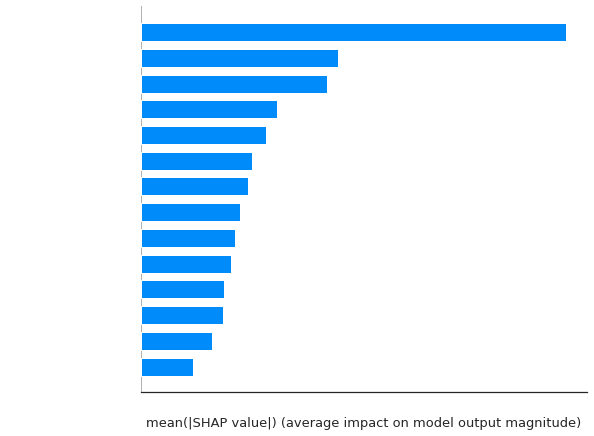

In [87]:
shap.summary_plot(shap_values_XGB_train, Xt, plot_type="bar",axis_color='white')

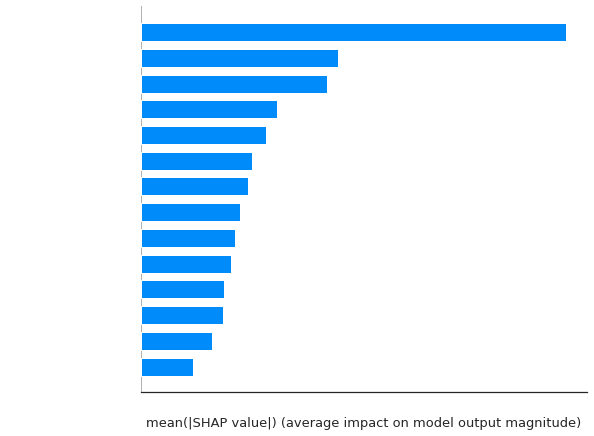

In [88]:
shap.summary_plot(shap_values_XGB_train, Xt, plot_type="bar",axis_color='white')

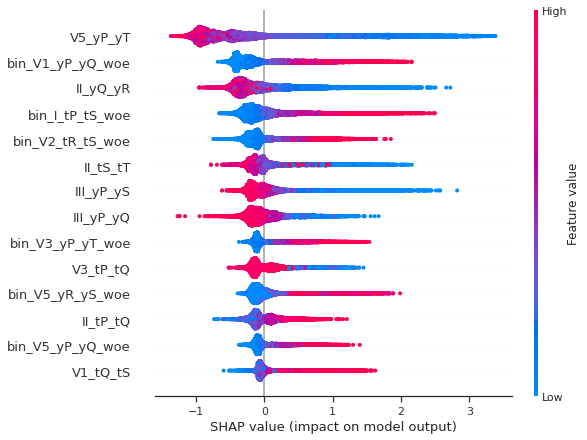

In [89]:
shap.summary_plot(shap_values_XGB_train, Xt)

# Strategy with Model

## Libraries

In [90]:
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline

## First I will create 8 groups splitting the odds

In [91]:
bins=np.arange(0,1,0.1)
dt['p'] = pd.cut(model.predict_proba(Xt)[:,1],bins=bins,include_lowest=True)
dv['p'] = pd.cut(model.predict_proba(Xv)[:,1],bins=bins,include_lowest=True)
aux_t = dt.pivot_table(index='p',columns='y',values=dc_feat['continuous'][0],fill_value=0,aggfunc='count').reset_index()
aux_t['type'] = 'train'
aux_v = dv.pivot_table(index='p',columns='y',values=dc_feat['continuous'][0],fill_value=0,aggfunc='count').reset_index()
aux_v['type'] ='validate'

In [92]:
aux_t_=get_use_model(aux_t)
# aux_t_['p']=aux_t_['p'].map({
#     pd.Interval(0.3, 0.4, closed='right'):pd.Interval(0, 0.4, closed='right'),
#     pd.Interval(0.4, 0.5, closed='right'):pd.Interval(0.4, 0.5, closed='right'),
#     pd.Interval(0.5, 0.6, closed='right'):pd.Interval(0.5, 0.6, closed='right'),
#     pd.Interval(0.6, 0.7, closed='right'):pd.Interval(0.6, 1, closed='right'),
#                 })
display(aux_t_)

get_graphs(aux_t_)

IV: 9.21


y              p     0     1   type  Total     %Dist       TNE        TE  \
0  (-0.001, 0.1]  1593    68  train   1661  0.161529  0.959061  0.040939   
1     (0.1, 0.2]  2073   237  train   2310  0.224643  0.897403  0.102597   
2     (0.2, 0.3]   998   262  train   1260  0.122532  0.792063  0.207937   
3     (0.3, 0.4]   632   302  train    934  0.090830  0.676660  0.323340   
4     (0.4, 0.5]   452   270  train    722  0.070213  0.626039  0.373961   
5     (0.5, 0.6]   315   377  train    692  0.067296  0.455202  0.544798   
6     (0.6, 0.7]   210   465  train    675  0.065642  0.311111  0.688889   
7     (0.7, 0.8]   159   683  train    842  0.081883  0.188836  0.811164   
8     (0.8, 0.9]    85  1102  train   1187  0.115433  0.071609  0.928391   

y   Acum NE    Acum E       Dif      Lift       WoE        IV  
0  0.244438  0.018056  0.226381  0.010179  3.153867  2.895633  
1  0.562529  0.080988  0.481541  0.025509  2.168692  1.723688  
2  0.715667  0.150558  0.565109  0.051700  1.337409  0.781217  
3  0.812644  0.230749  0.581895  0.080393  0.738462  0.260913  
4  0.882001  0.302443  0.579558  0.092979  0.515260  0.129886  
5  0.930336  0.402549  0.527787  0.135454 -0.179673  0.016098  
6  0.962559  0.526022  0.436537  0.171279 -0.794930  0.300307  
7  0.986957  0.707382  0.279575  0.201681 -1.457591  0.907099  
8  1.000000  1.000000  0.000000  0.230827 -2.562231  2.195273

None

None

None

KS: 0.5818950494360474


None

None

In [93]:
aux_v_=get_use_model(aux_v)
display(aux_v_)
get_graphs(aux_v_)

IV: 6.07


y              p    0    1      type  Total     %Dist       TNE        TE  \
0  (-0.001, 0.1]  382   25  validate    407  0.156418  0.938575  0.061425   
1     (0.1, 0.2]  510  105  validate    615  0.236357  0.829268  0.170732   
2     (0.2, 0.3]  230   76  validate    306  0.117602  0.751634  0.248366   
3     (0.3, 0.4]  127   78  validate    205  0.078786  0.619512  0.380488   
4     (0.4, 0.5]  112   85  validate    197  0.075711  0.568528  0.431472   
5     (0.5, 0.6]   71   95  validate    166  0.063797  0.427711  0.572289   
6     (0.6, 0.7]   65  130  validate    195  0.074942  0.333333  0.666667   
7     (0.7, 0.8]   54  159  validate    213  0.081860  0.253521  0.746479   
8     (0.8, 0.9]   48  250  validate    298  0.114527  0.161074  0.838926   

y   Acum NE    Acum E       Dif      Lift       WoE        IV  
0  0.238899  0.024925  0.213974  0.014920  2.726545  2.391588  
1  0.557849  0.129611  0.428237  0.041472  1.580450  1.040784  
2  0.701689  0.205384  0.496305  0.060329  1.107346  0.557292  
3  0.781113  0.283151  0.497963  0.092422  0.487478  0.116519  
4  0.851157  0.367896  0.483261  0.104807  0.275848  0.037807  
5  0.895560  0.462612  0.432948  0.139012 -0.291197  0.042101  
6  0.936210  0.592223  0.343987  0.161936 -0.693147  0.231049  
7  0.969981  0.750748  0.219233  0.181323 -1.079920  0.532355  
8  1.000000  1.000000  0.000000  0.203779 -1.650260  1.118633

None

None

None

KS: 0.49796264739240687


None

None

In [94]:
dc_feat.keys()

dict_keys(['dates', 'lists', 'texts', 'ids', 'target', 'continuous', 'discretes'])

### Saving set bins

In [95]:
pickle.dump(bins, open('../transforms/bins.pkl', 'wb'))